Items for ablation study:

Shrink the model (Change ```dims``` of ```ODEFunc```)

Train for fewer timesteps (Edit batch size?)

Add varied levels of noise (Add noise after grabbing the batch)

Use fewer training trajectories (Edit ```num_epochs``` variable)

# Imports + Necessary Functions

In [2]:
!pip install torchdiffeq

In [62]:
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.utils.data.dataloader import DataLoader
import argparse
from tqdm import tqdm
from scipy.integrate import solve_ivp
from torch.utils.data.dataloader import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
class FeedForward(nn.Module):
    #So bog basic it should tap for black mana
    #DT That one's for you
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 30)
        self.linear2 = nn.Linear(30,30)
        self.linear3 = nn.Linear(30,30)
        self.linear4 = nn.Linear(30,4)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = torch.clamp(x, -1e6, 1e6)
        return x


class Pendulum_Data(Dataset):
    def __init__(self, min_length=1, max_length=1, G=9.81, delta_t=0.005, size=2**15):
        self.__dict__.update(locals())

    @staticmethod
    def derivatives(t, state, params, G=9.81):
        L1, L2, m1, m2 = params
        theta1, z1, theta2, z2 = state
        delta = theta2 - theta1

        denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
        denominator2 = (L2 / L1) * denominator1

        dtheta1_dt = z1
        dz1_dt = (
                (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
                 + m2 * G * np.sin(theta2) * np.cos(delta)
                 + m2 * L2 * z2 ** 2 * np.sin(delta)
                 - (m1 + m2) * G * np.sin(theta1))
                / denominator1
        )
        dtheta2_dt = z2
        dz2_dt = (
                (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
                 + (m1 + m2) * G * np.sin(theta1) * np.cos(delta)
                 - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
                 - (m1 + m2) * G * np.sin(theta2))
                / denominator2
        )

        return np.array([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])

    def run_simulation(self, theta1_init, theta2_init, l1, l2, m1, m2, v1, v2, t_eval):
        state_0 = [theta1_init, v1, theta2_init, v2]
        # Solve the system
        params = [[l1, l2, m1, m2]]
        solution = solve_ivp(
            Pendulum_Data.derivatives, (0, t_eval[-1]), state_0, t_eval=t_eval, args=params,
        )
        # Return data as dictionary
        return np.array(
            [[l1] * len(t_eval), [l2] * len(t_eval), [m1] * len(t_eval), [m2] * len(t_eval), *solution.y, t_eval]).T

    def __getitem__(self, i):
        t_final = (np.random.randint(self.min_length, self.max_length + 1)+1) * self.delta_t  # the extra +1 makes it so the arange has the right number of steps
        theta1_init, theta2_init = np.random.uniform(-np.pi, np.pi, 2)
        l1, l2 = np.clip(np.random.normal(1, .5, 2), 0.1, 3)
        m1, m2 = np.clip(np.random.normal(1, .5, 2), 0.1, 3)
        v1, v2 = np.random.normal(size=2)
        theta =  self.run_simulation(theta1_init=theta1_init, theta2_init=theta2_init, l1=l1, l2=l2, m1=m1, m2=m2, v1=v1,
                                   v2=v2, t_eval=np.arange(0, t_final, self.delta_t))
        return theta[:-1], theta[1:]

    def __len__(self):
        return self.size

In [5]:
class ODEFunc(nn.Module):
    def __init__(self, dims):
        super(ODEFunc, self).__init__()
        self.num_calls = 0
        self.net = nn.Sequential(
            nn.Linear(5, dims[0]),  # state: (theta1, w1, theta2, w2, t)
            nn.Tanh(),
        )
        if len(dims) > 1:
            for i in range(1,len(dims)):
                self.net.append(nn.Linear(dims[i-1], dims[i]))
                self.net.append(nn.Tanh())
        self.net.append(nn.Linear(dims[-1], 5))

    def forward(self, t, y):
        # y has shape (batch_size, 4)
        self.num_calls += 1
        return self.net(y)

In [28]:
def one_step_error(y, y_hat, lambda_=0):
    """
    Returns L(t-1) = ||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||
    Agrees with (3.13) when lambda_=1.  Note the shift in index.

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    lambda : regularization parameter
    """
    theta, theta_hat = y[:, :2], y_hat[:, :2]
    theta_prime, theta_prime_hat = y[:, 2:-1], y_hat[:, 2:-1]

    return (np.linalg.norm(theta - theta_hat, axis=1) +
            lambda_ * np.linalg.norm(theta_prime - theta_prime_hat, axis=1))

def total_divergence_at_time(t_idx, y, y_hat, lambda_=0):
    """
    Returns ||theta - theta_hat|| + lambda_ ||theta' - theta_hat'||

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    """
    theta, theta_hat = y[:t_idx, :2], y_hat[:t_idx, :2]
    theta_prime, theta_prime_hat = y[:t_idx, 2:-1], y_hat[:t_idx, 2:-1]

    return (np.linalg.norm(theta - theta_hat) +
               lambda_ * np.linalg.norm(theta_prime - theta_prime_hat))

def time_to_divergence(y, y_hat, lambda_=0, tol=1e-1):
    """
    Returns min {t : (||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||) >= tol}

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    tol : maximum error
    """
    idx = np.where(one_step_error(y, y_hat, lambda_) >= tol)
    return np.min(idx[0]) if len(idx[0]) != 0 else len(y_hat)

def global_error(t_idx, y, y_hat, lambda_=0):
    """
    Returns max_{t<T} (||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||)
    Agrees with spherical error (3.11) when lambda_=1 and t_idx is as large as possible

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    """
    return max(one_step_error(y, y_hat, lambda_)[:t_idx])

# Training

In [ ]:
def train_model(num_epochs, dims, std_dev, min_steps, model_idx):
    max_steps = min_steps + 5
    G = 9.81
    delta_t = 0.005
    lr = 1e-3
    weight_decay = 1e-4
    batch_size = 1
    lam = 0.5
    save_every = 100
    val_every = 25
    val_size = 100

    # Set model, optimizer and loss
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEFunc(dims)
    criterion = nn.MSELoss()
    model = model.to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    losses = []

    # Training
    data = Pendulum_Data(min_steps, max_steps, G, delta_t, batch_size)
    dl = DataLoader(data, batch_size=batch_size)
    train_losses = []
    val_losses = []

    for i in tqdm(range(num_epochs)):
        train_losses_local = []
        # each batch is as long as the dataset, so an epoch is one batch
        for X_batch, y_batch in dl:
            X_batch += np.random.normal(0, std_dev, X_batch.shape)
            X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
            optimizer.zero_grad()

            # get prediction and make a tuple to pass to the loss
            y_pred = odeint(model, X_batch[:, :, 4:], delta_t * torch.arange(len(X_batch)+1))[1:]
            y_batch = y_batch[:, :, 4:]  # remove mass/length information from outputs
            loss_args = (y_pred.squeeze(), y_batch.squeeze())

            # calculate loss and backprop
            loss = criterion(*loss_args)
            loss.backward()
            train_losses_local.append(loss.item())
            optimizer.step()
        train_losses.append(np.mean(train_losses_local))

        if (i + 1) % val_every == 0:
            model.eval()
            val_losses_local = []

            # run val_size batches to test validation error
            for j in range(val_size):
                for X_batch, y_batch in dl:
                    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
                    optimizer.zero_grad()

                    # get prediction
                    y_pred = None
                    loss_args = None
                    y_pred = odeint(model, X_batch[:, :, 4:], delta_t * torch.arange(len(X_batch) + 1))[1:]
                    y_batch = y_batch[:, :, 4:]  # remove mass/length information from outputs
                    loss_args = (y_pred.squeeze(), y_batch.squeeze())

                    # calculate loss, then average
                    loss = criterion(*loss_args)
                    val_losses_local.append(loss.item())
            val_losses.append(np.mean(val_losses_local))
            model.train()

        # if (i + 1) % save_every == 0:
    torch.save(model.state_dict(), f'Ablation_models/model_{model_idx}.pt')
    torch.save(train_losses, f'Ablation_models/model_{model_idx}_train_losses.pt')
    torch.save(val_losses, f'Ablation_models/model_{model_idx}_val_losses.pt')

    OSE = one_step_error(y_pred.squeeze().detach().numpy(), y_batch.squeeze().detach().numpy(), 1)
    TD = [total_divergence_at_time(idx, y_batch.squeeze().detach().numpy(), y_pred.squeeze().detach().numpy(), 1) for idx in range(len(X_batch) + 1)]
    torch.save(OSE, f'Ablation_models/model_{model_idx}_OSE.pt')
    torch.save(TD, f'Ablation_models/model_{model_idx}_TD.pt')

    plt.subplot(121)
    plt.plot(OSE)
    plt.title('One Step Error')

    plt.subplot(122)
    plt.plot(TD)
    plt.title('Total Divergence')

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses

In [7]:
epochs = [200, 500, 1000]
dim_sets = [[64,128,64],[64,64],[32]]
noise = [0, 0.05, 0.5]
steps = [3, 10, 18]



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 200
Min_steps: 3
1/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.55it/s]


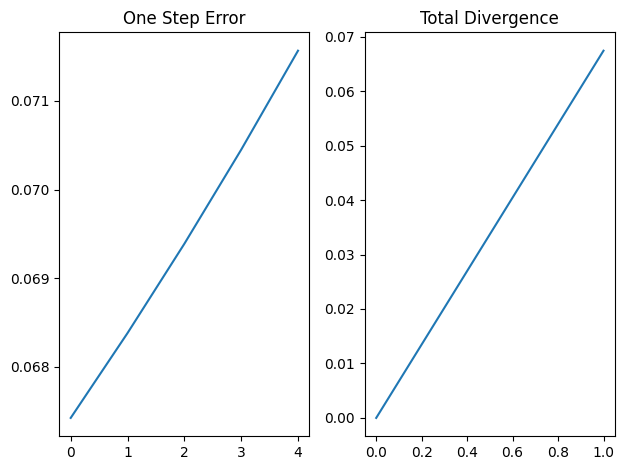

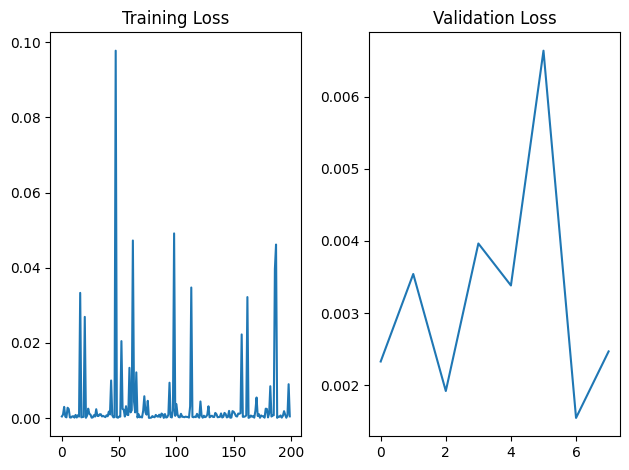



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 200
Min_steps: 10
2/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.57it/s]


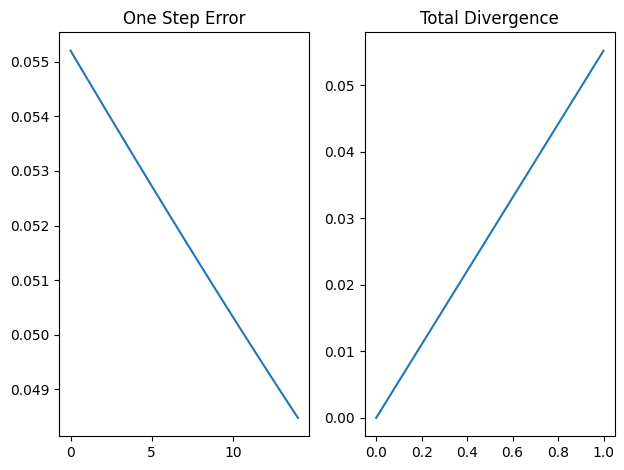

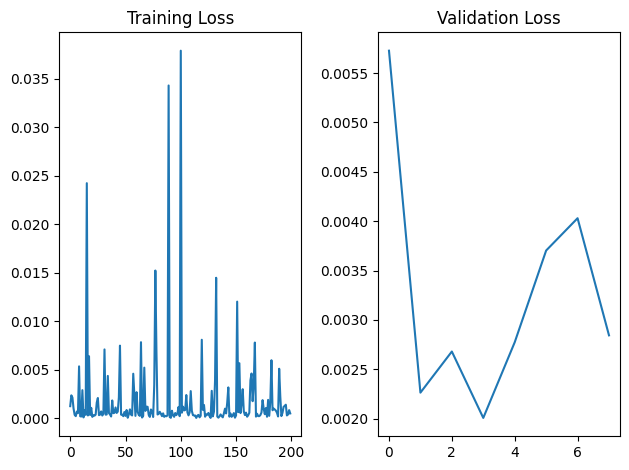



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 200
Min_steps: 18
3/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.03it/s]


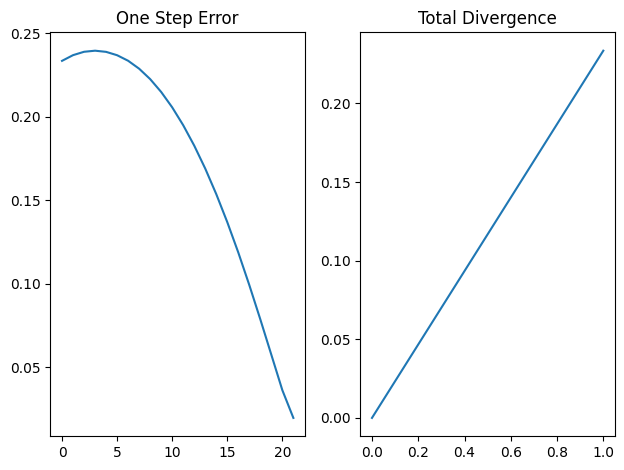

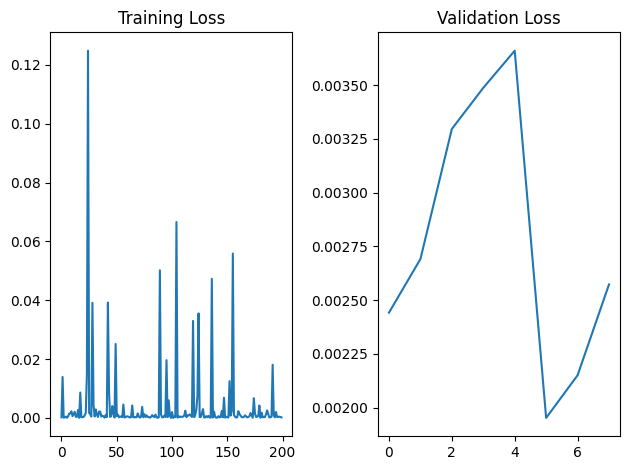



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 500
Min_steps: 3
4/81 trainings completed



100%|██████████| 500/500 [00:27<00:00, 18.49it/s]


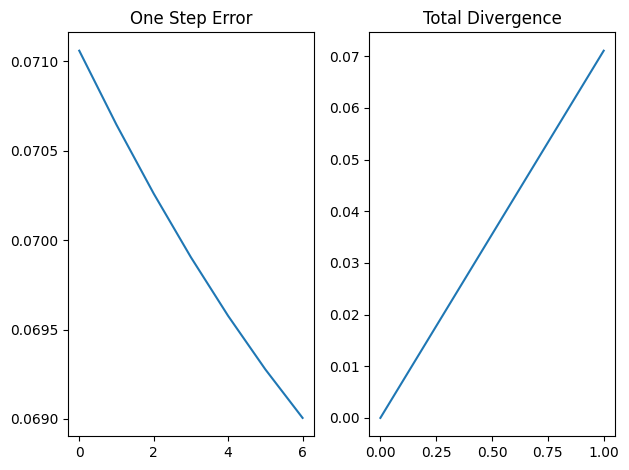

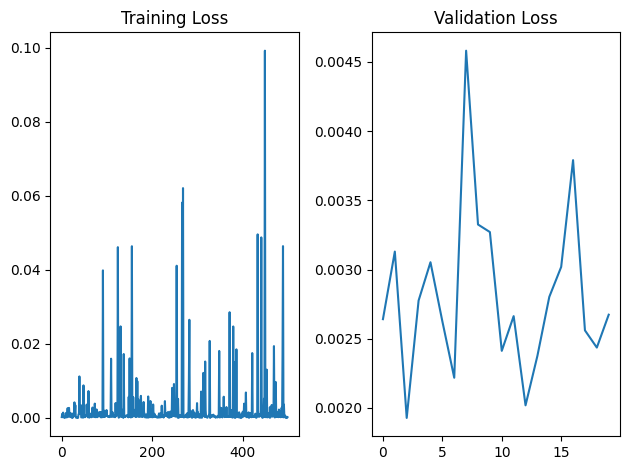



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 500
Min_steps: 10
5/81 trainings completed



100%|██████████| 500/500 [00:27<00:00, 18.11it/s]


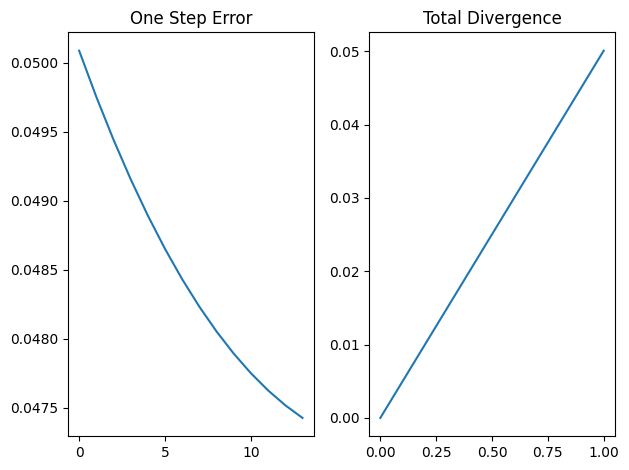

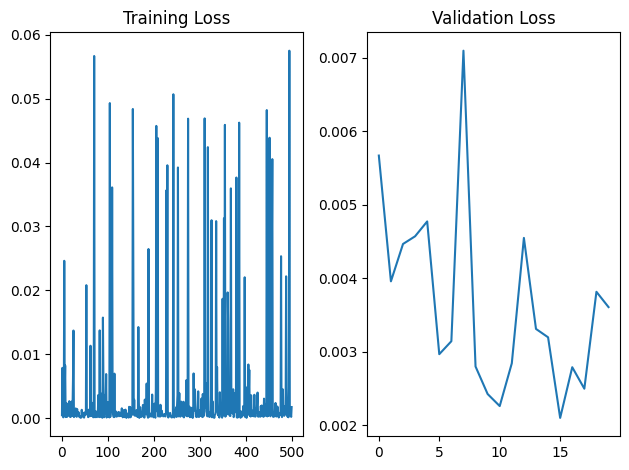



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 500
Min_steps: 18
6/81 trainings completed



100%|██████████| 500/500 [00:28<00:00, 17.25it/s]


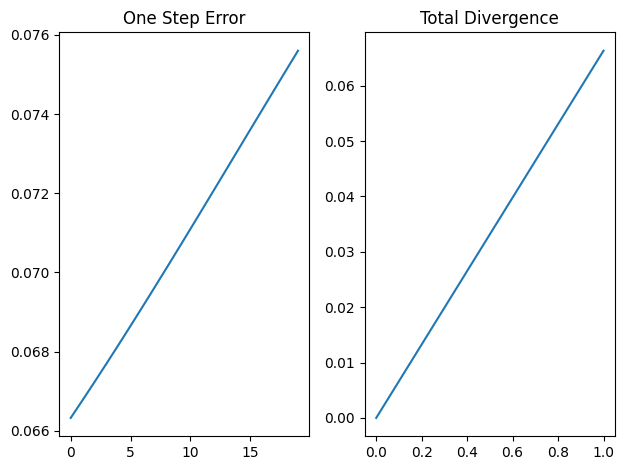

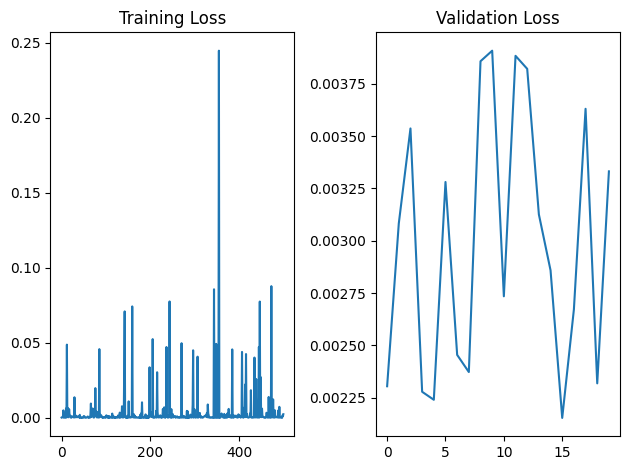



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 1000
Min_steps: 3
7/81 trainings completed



100%|██████████| 1000/1000 [01:01<00:00, 16.35it/s]


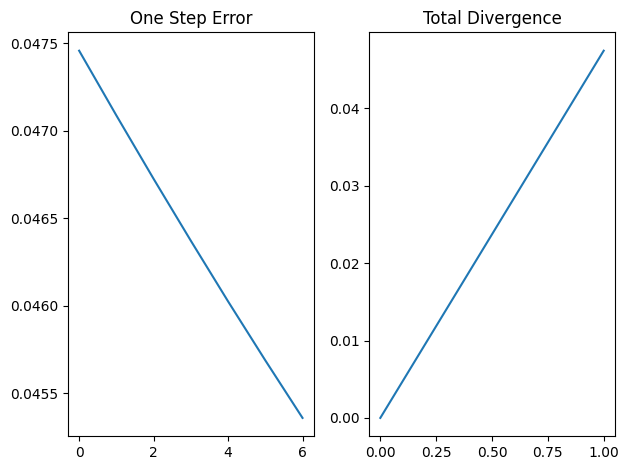

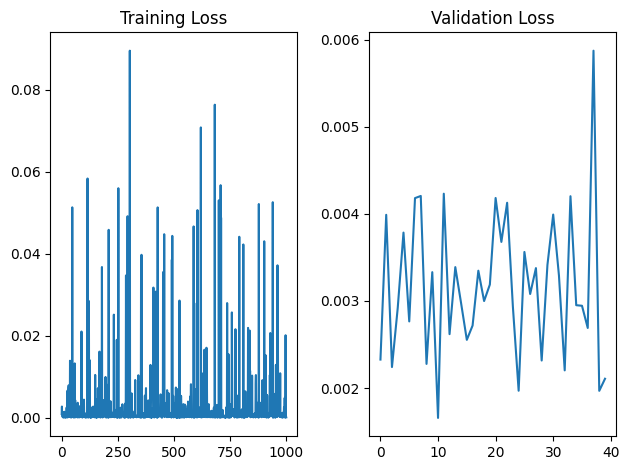



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 1000
Min_steps: 10
8/81 trainings completed



100%|██████████| 1000/1000 [01:00<00:00, 16.58it/s]


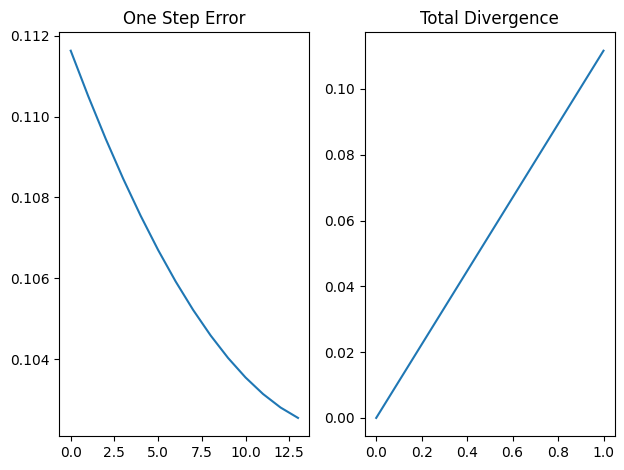

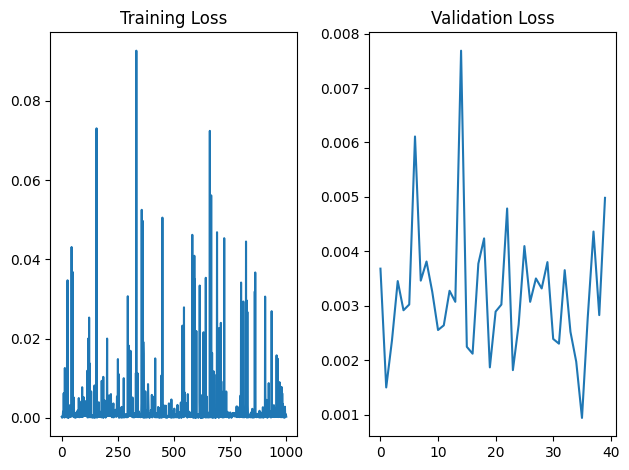



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0
Epochs: 1000
Min_steps: 18
9/81 trainings completed



100%|██████████| 1000/1000 [00:58<00:00, 17.00it/s]


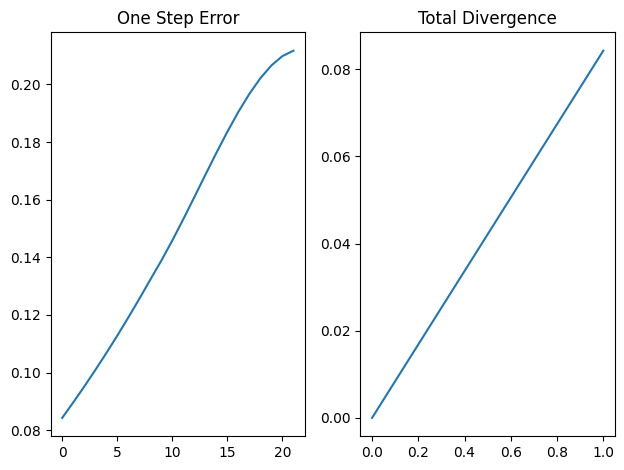

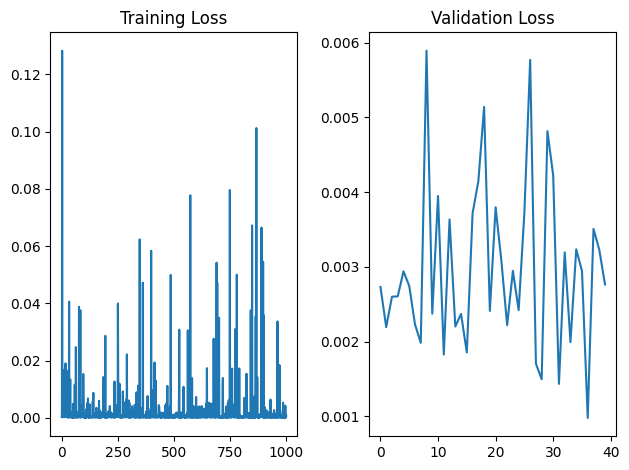



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 200
Min_steps: 3
10/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 18.16it/s]


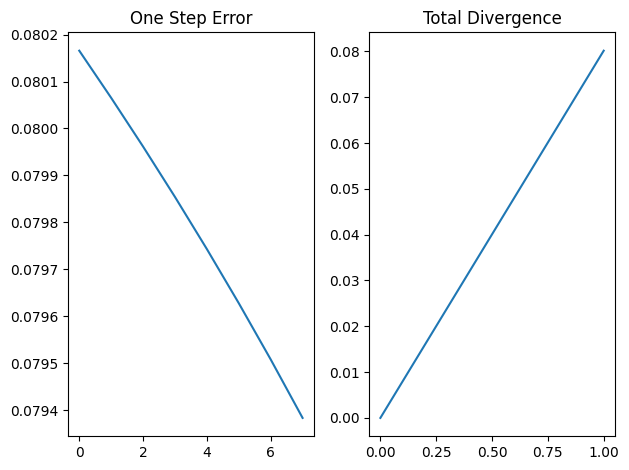

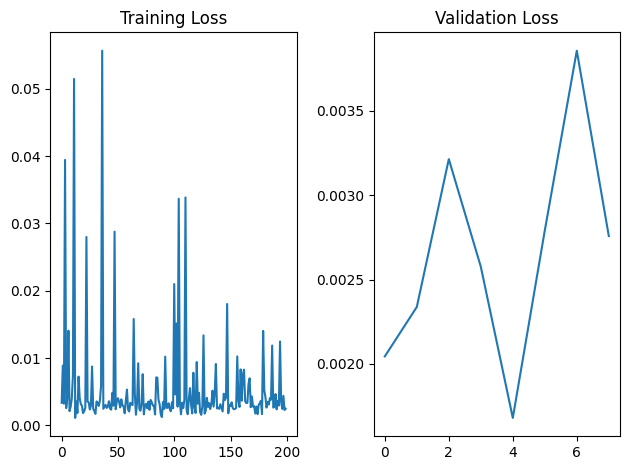



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 200
Min_steps: 10
11/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.59it/s]


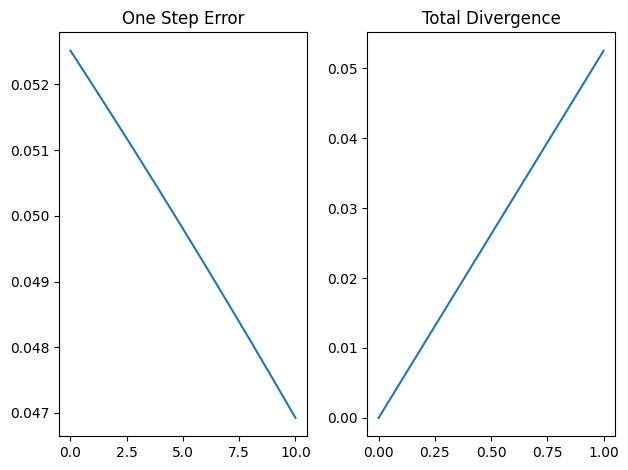

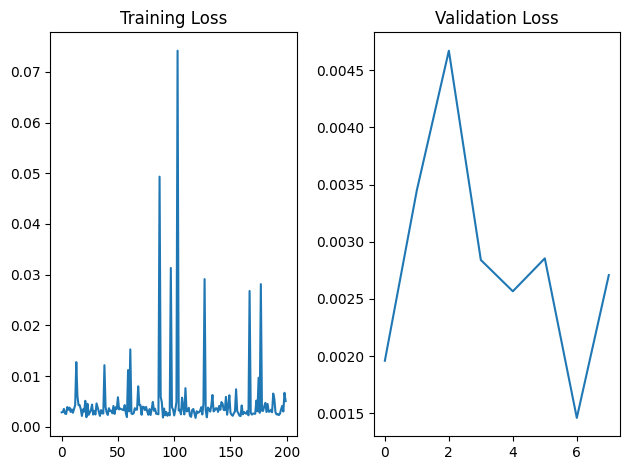



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 200
Min_steps: 18
12/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.26it/s]


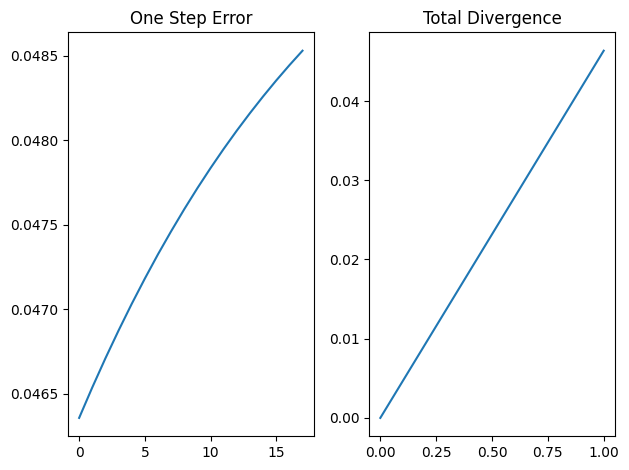

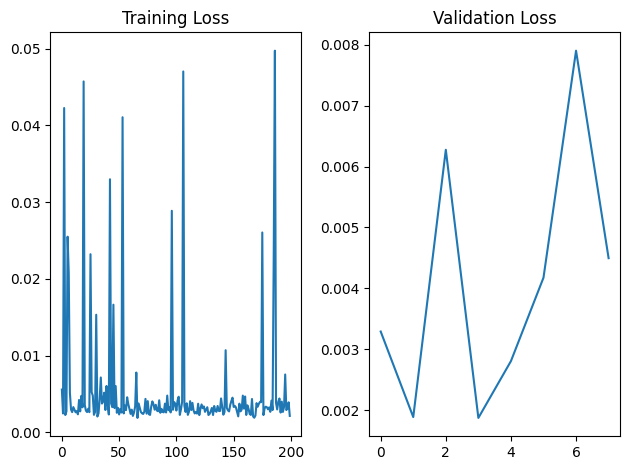



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 500
Min_steps: 3
13/81 trainings completed



100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


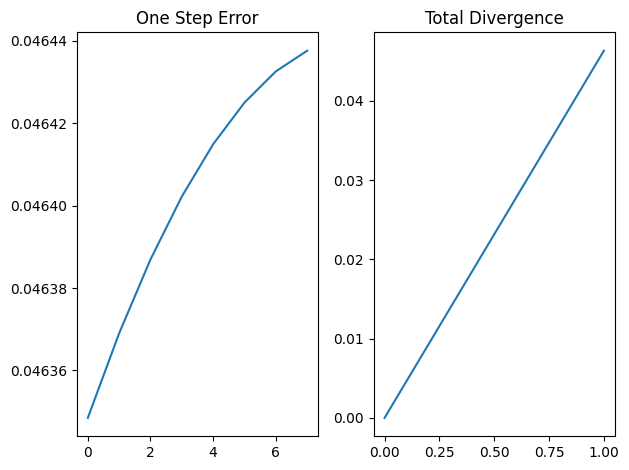

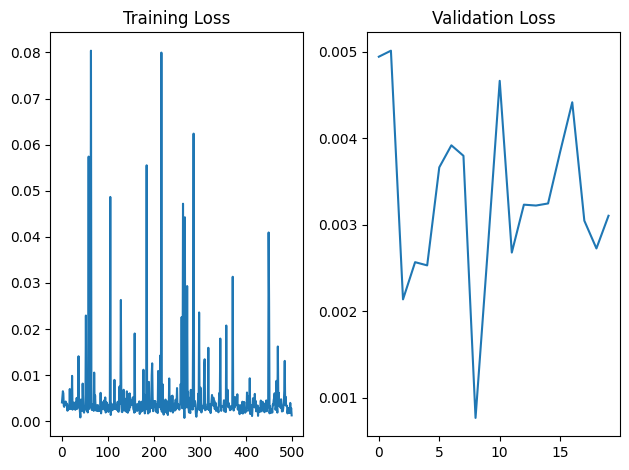



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 500
Min_steps: 10
14/81 trainings completed



100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


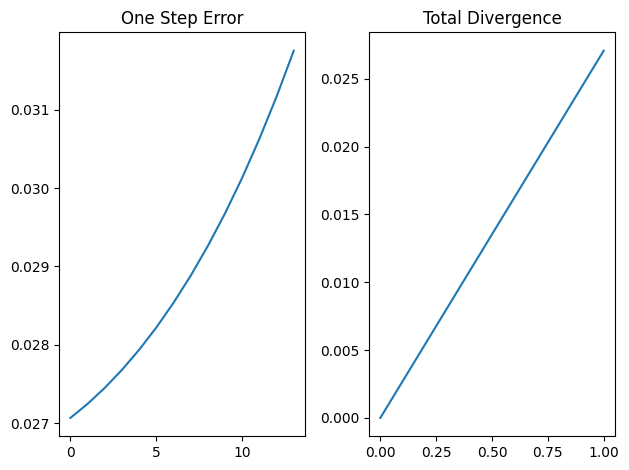

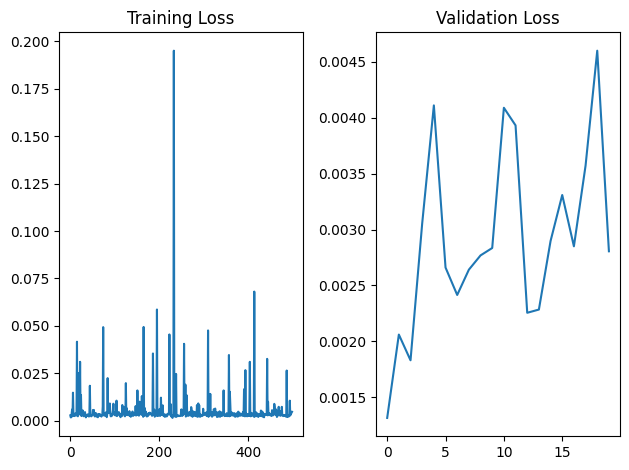



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 500
Min_steps: 18
15/81 trainings completed



100%|██████████| 500/500 [00:29<00:00, 16.73it/s]


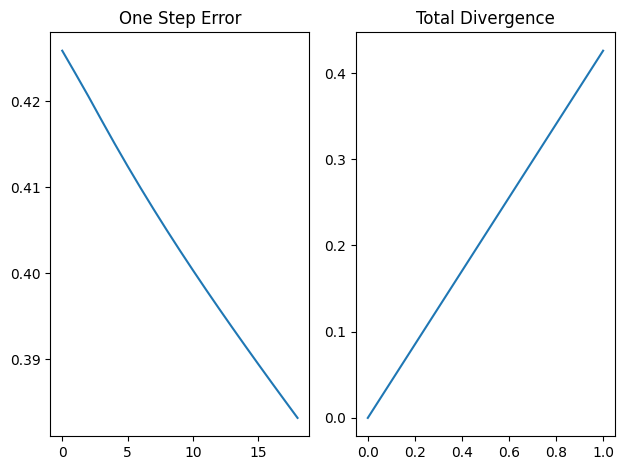

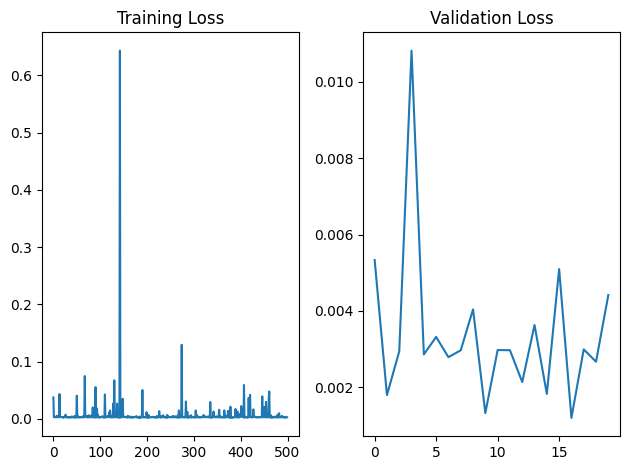



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 1000
Min_steps: 3
16/81 trainings completed



100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s]


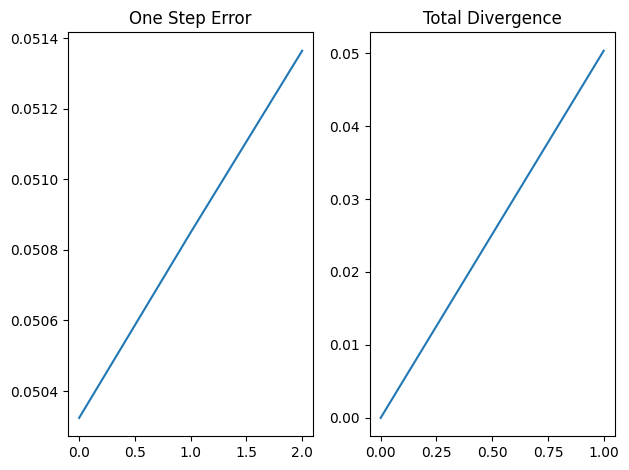

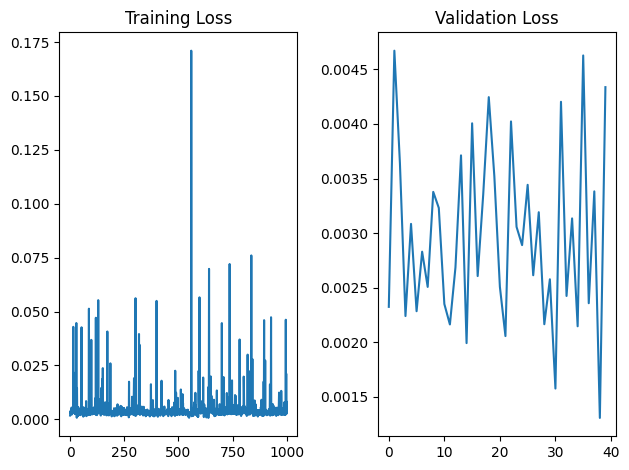



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 1000
Min_steps: 10
17/81 trainings completed



100%|██████████| 1000/1000 [01:00<00:00, 16.52it/s]


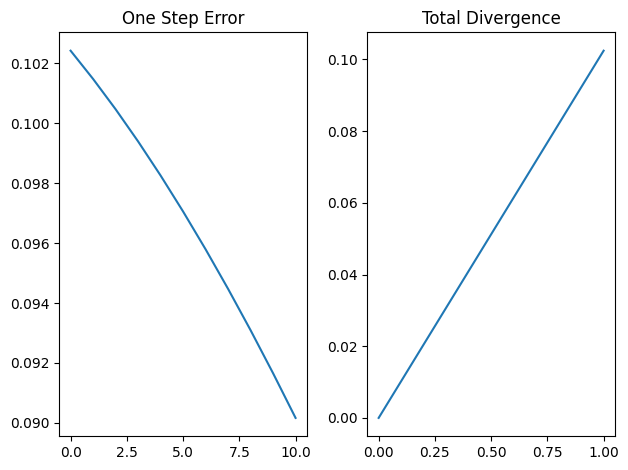

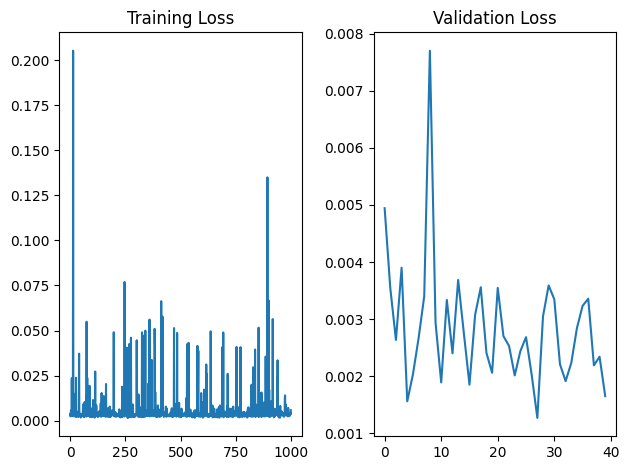



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.05
Epochs: 1000
Min_steps: 18
18/81 trainings completed



100%|██████████| 1000/1000 [01:00<00:00, 16.65it/s]


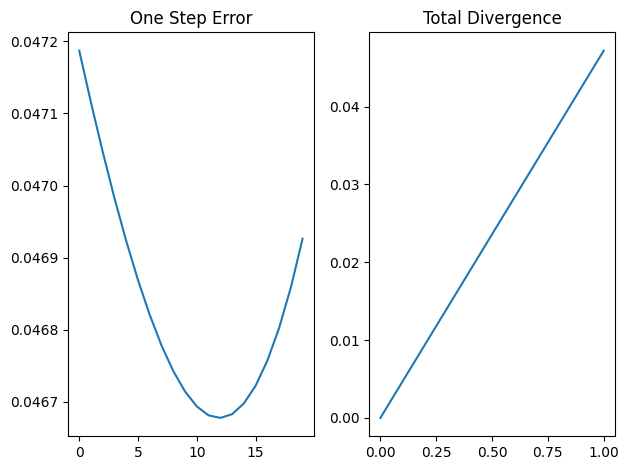

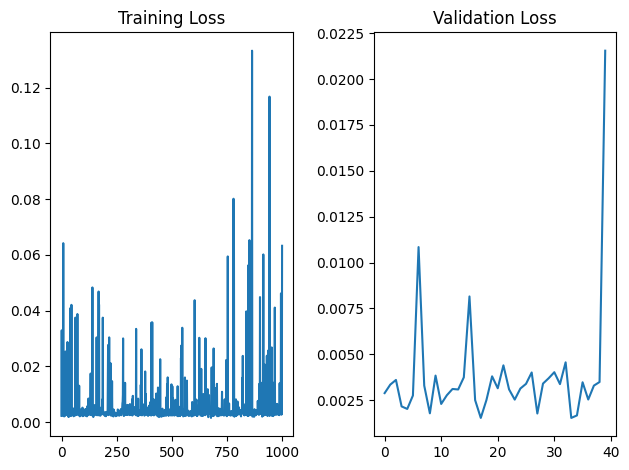



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 200
Min_steps: 3
19/81 trainings completed



100%|██████████| 200/200 [00:12<00:00, 16.48it/s]


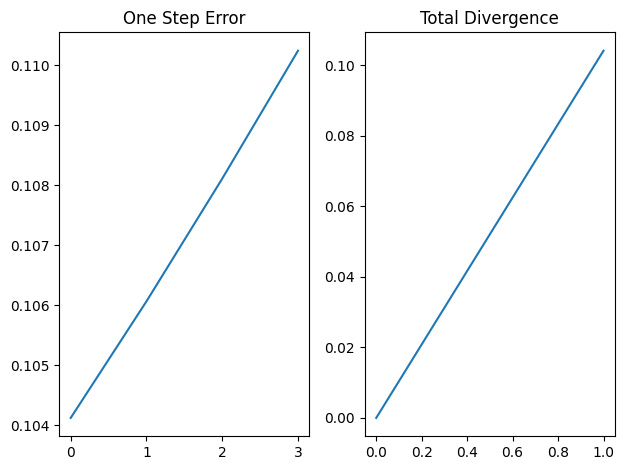

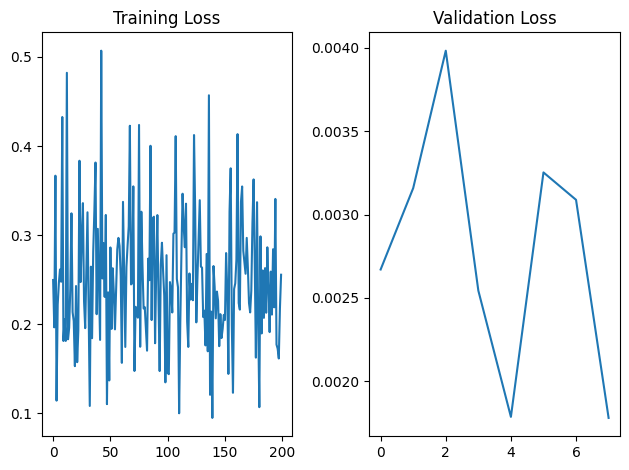



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 200
Min_steps: 10
20/81 trainings completed



100%|██████████| 200/200 [00:14<00:00, 13.99it/s]


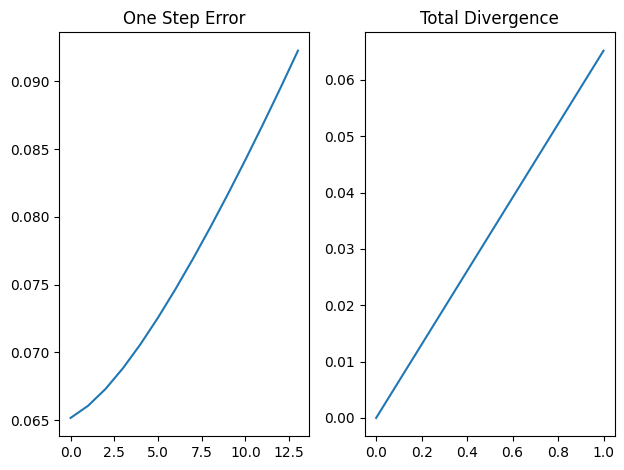

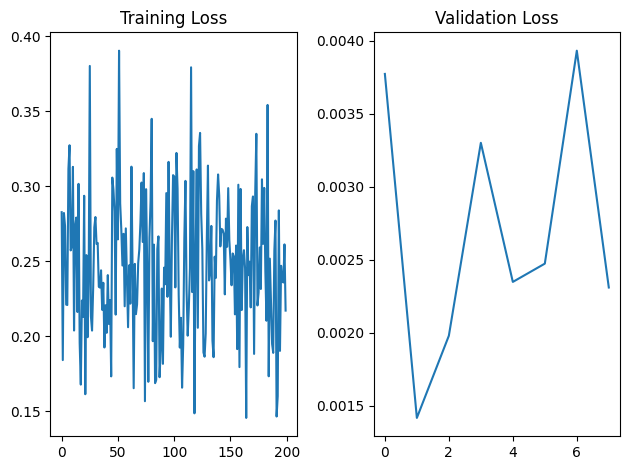



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 200
Min_steps: 18
21/81 trainings completed



100%|██████████| 200/200 [00:15<00:00, 12.70it/s]


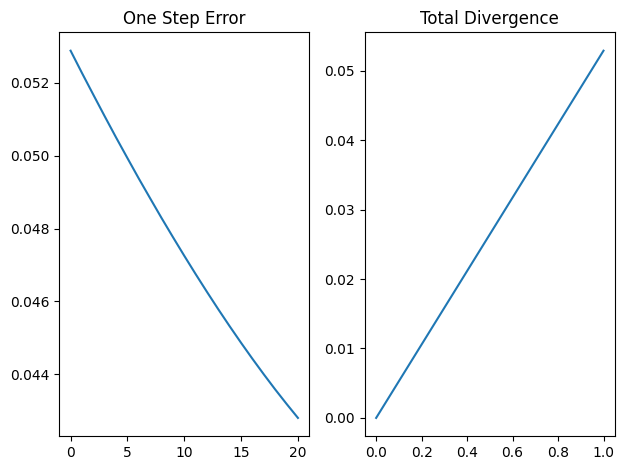

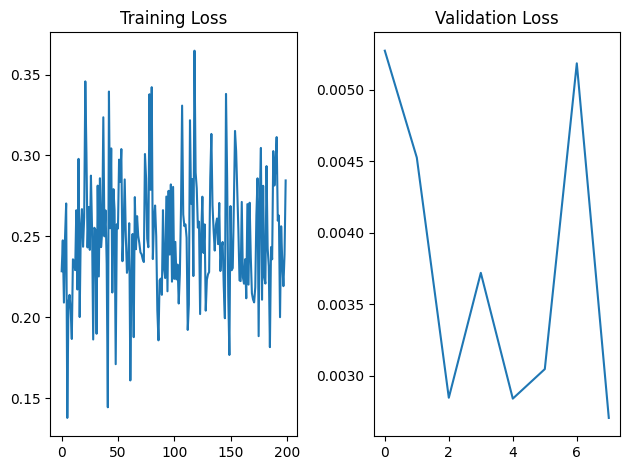



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 500
Min_steps: 3
22/81 trainings completed



100%|██████████| 500/500 [00:56<00:00,  8.87it/s]


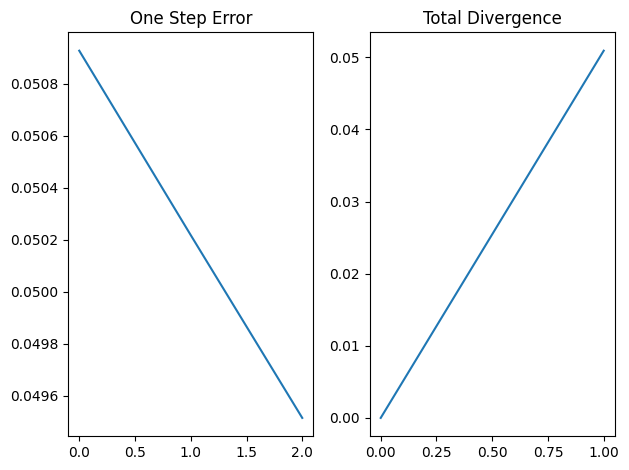

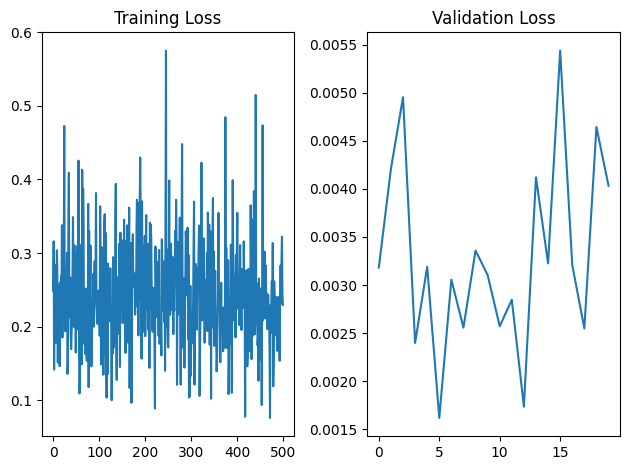



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 500
Min_steps: 10
23/81 trainings completed



100%|██████████| 500/500 [00:58<00:00,  8.53it/s]


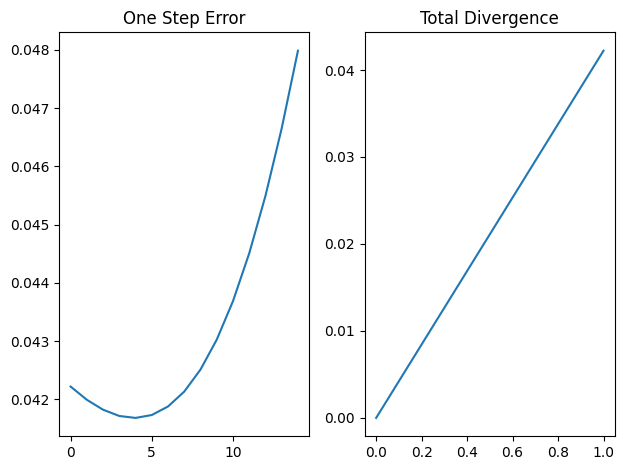

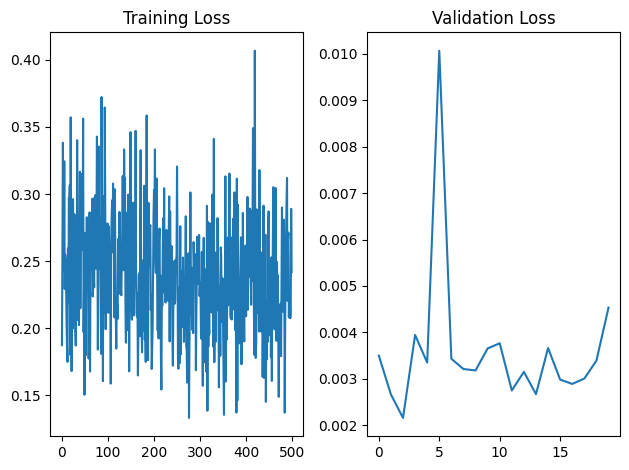



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 500
Min_steps: 18
24/81 trainings completed



100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


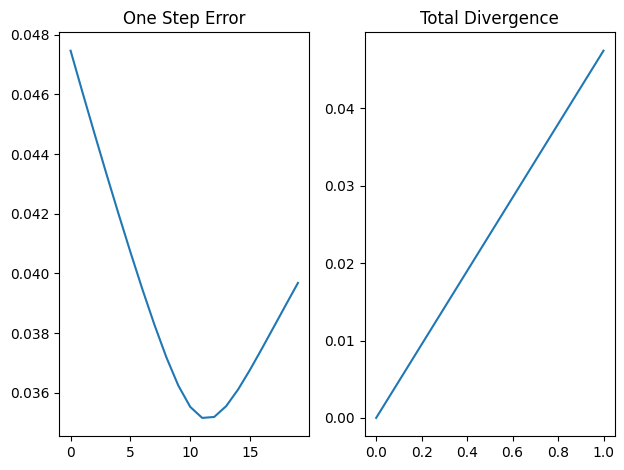

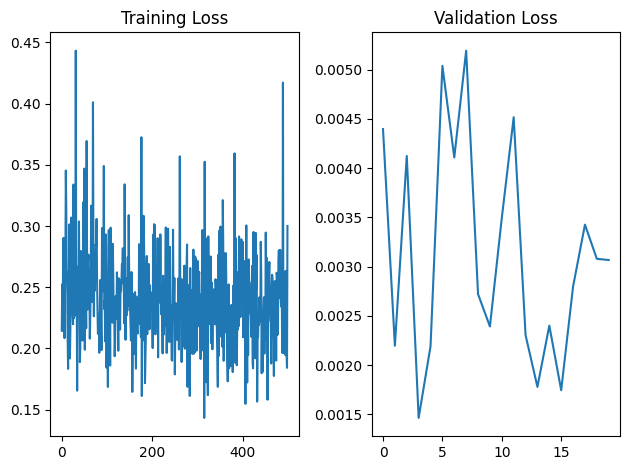



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 1000
Min_steps: 3
25/81 trainings completed



100%|██████████| 1000/1000 [02:51<00:00,  5.83it/s]


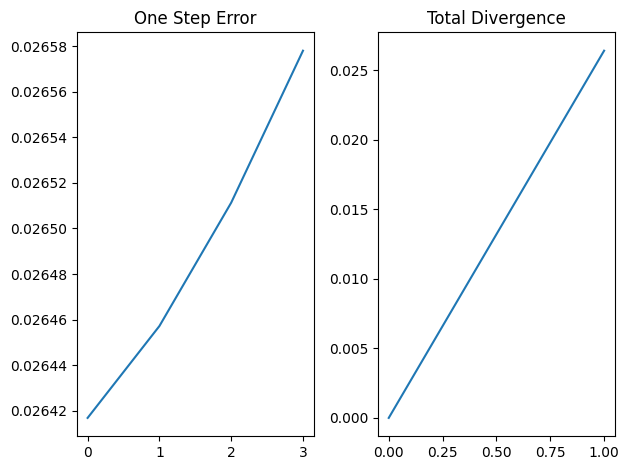

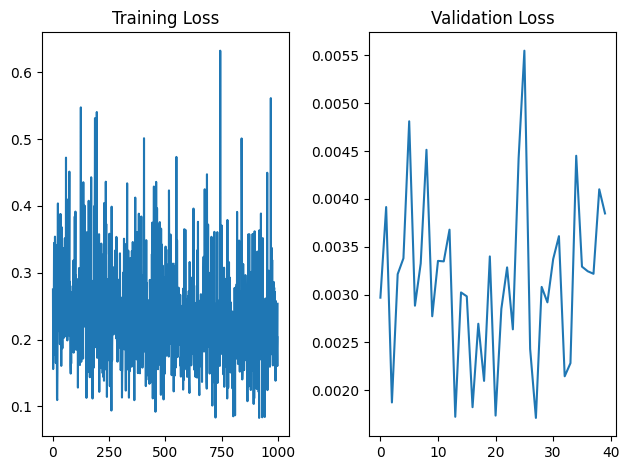



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 1000
Min_steps: 10
26/81 trainings completed



100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


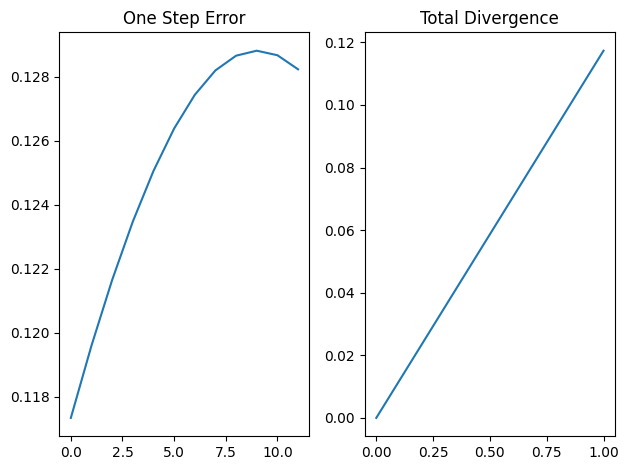

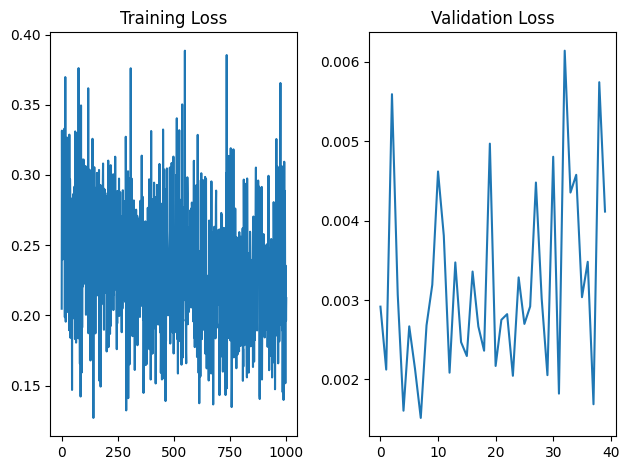



ODEFunc dimensions: [64, 128, 64]
Noise variance: 0.5
Epochs: 1000
Min_steps: 18
27/81 trainings completed



100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s]


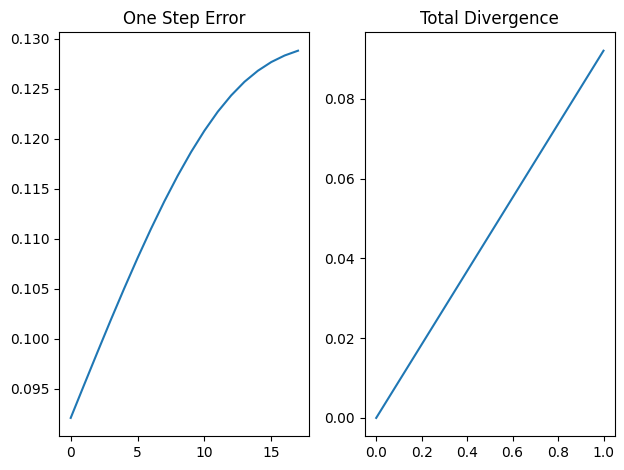

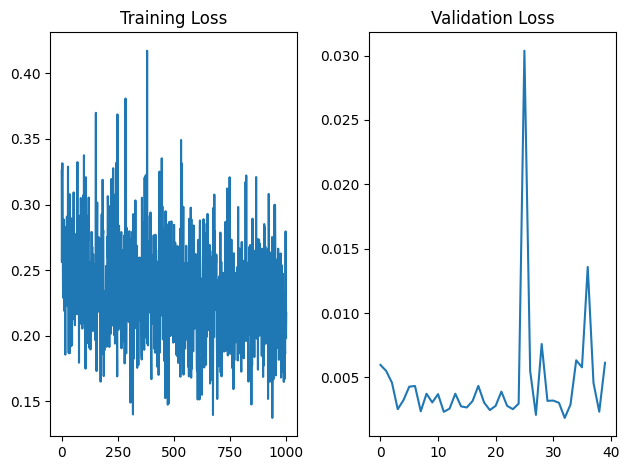



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 200
Min_steps: 3
28/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.09it/s]


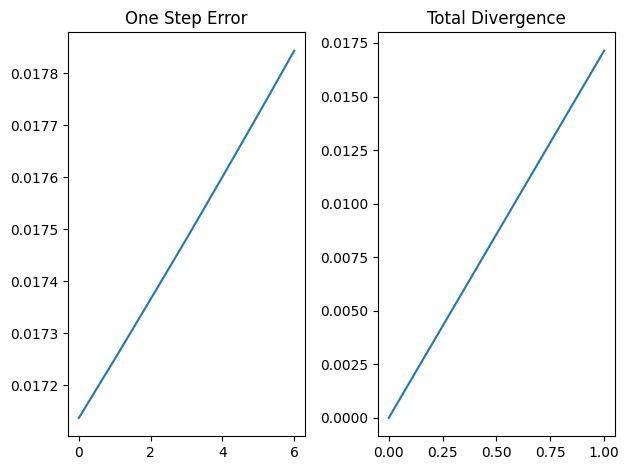

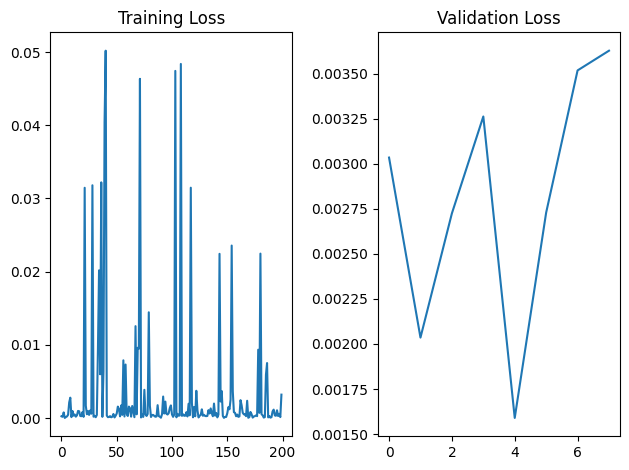



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 200
Min_steps: 10
29/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.26it/s]


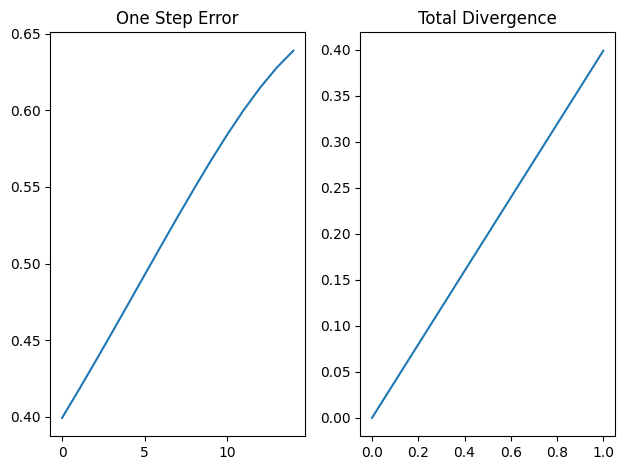

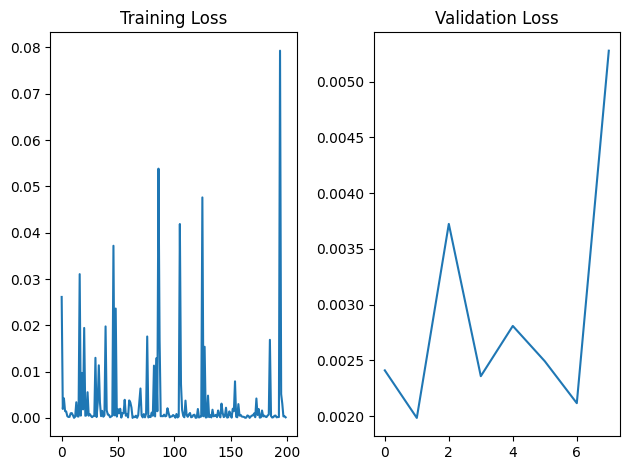



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 200
Min_steps: 18
30/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.34it/s]


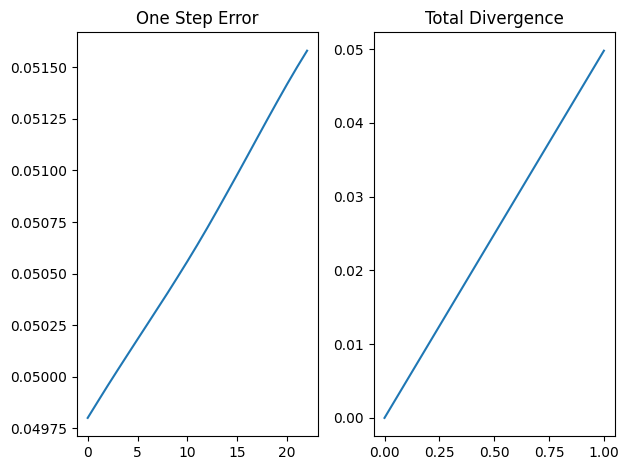

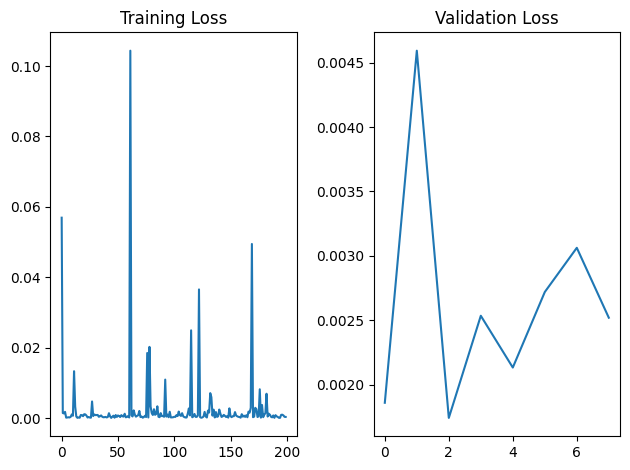



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 500
Min_steps: 3
31/81 trainings completed



100%|██████████| 500/500 [00:25<00:00, 19.41it/s]


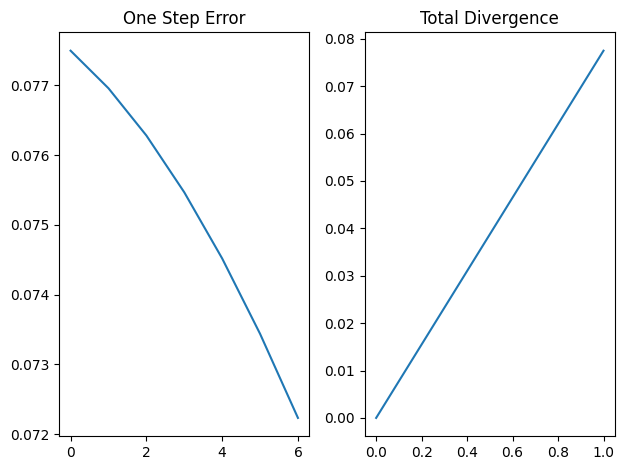

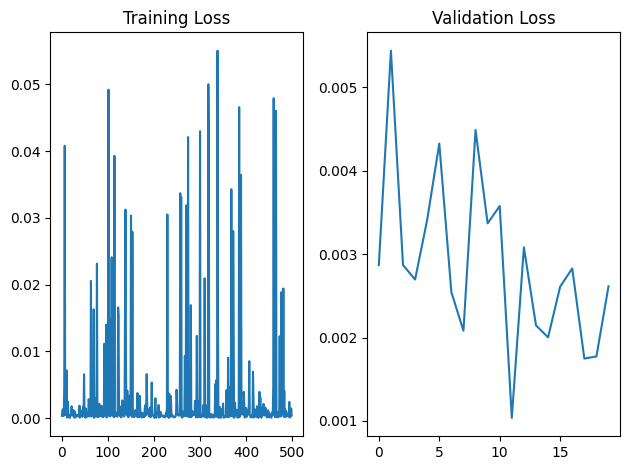



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 500
Min_steps: 10
32/81 trainings completed



100%|██████████| 500/500 [00:26<00:00, 18.66it/s]


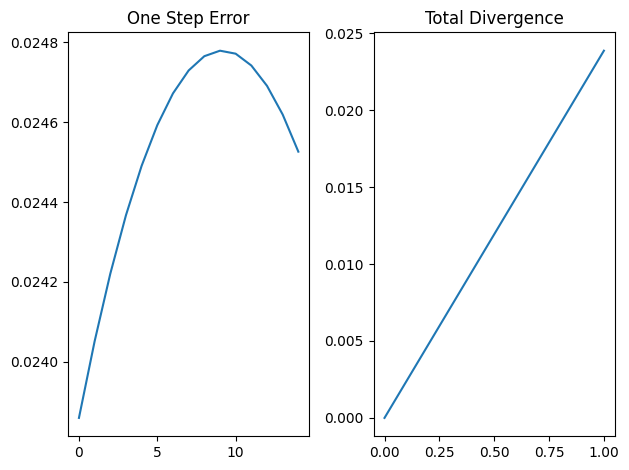

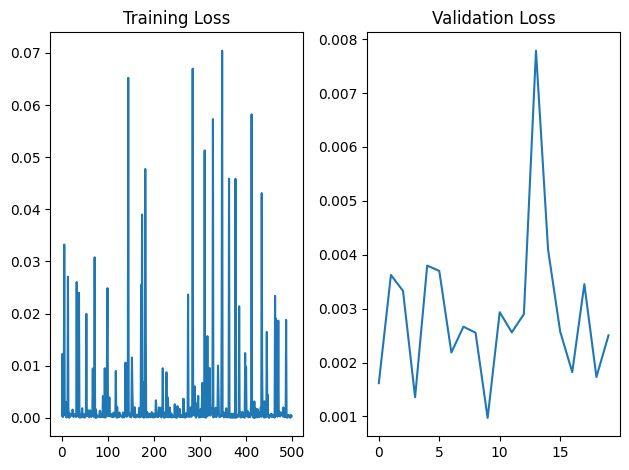



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 500
Min_steps: 18
33/81 trainings completed



100%|██████████| 500/500 [00:27<00:00, 18.28it/s]


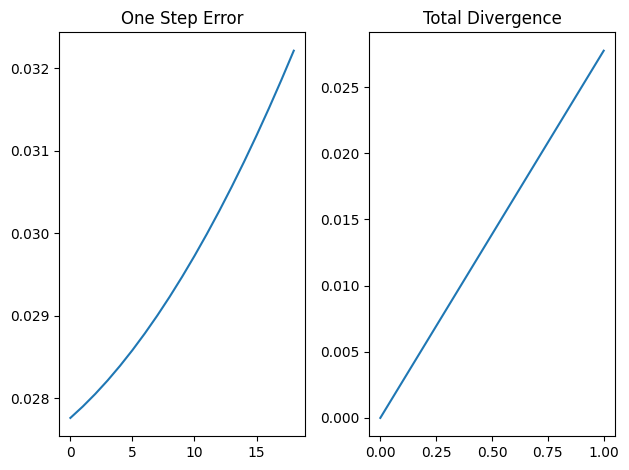

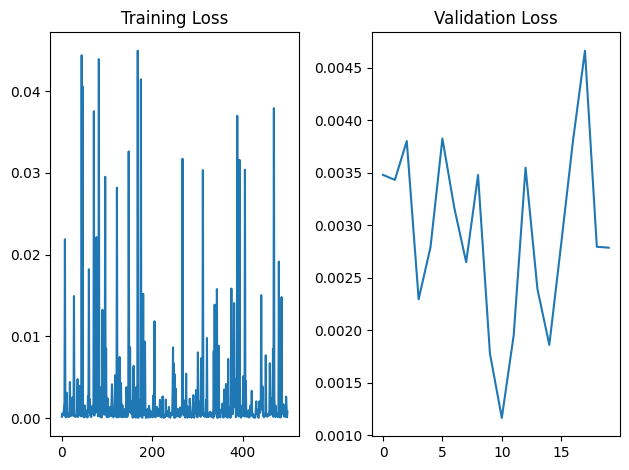



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 1000
Min_steps: 3
34/81 trainings completed



100%|██████████| 1000/1000 [00:53<00:00, 18.81it/s]


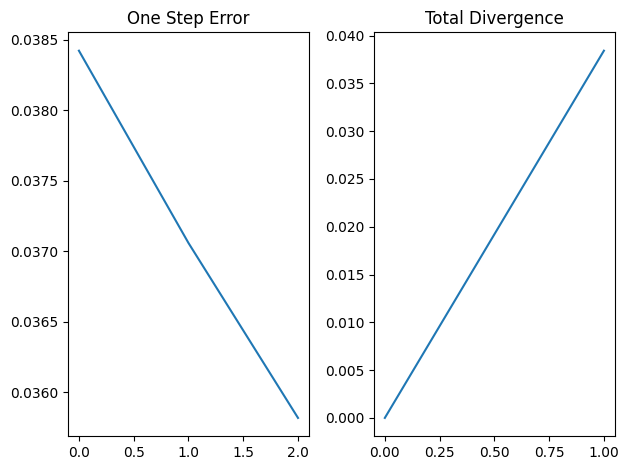

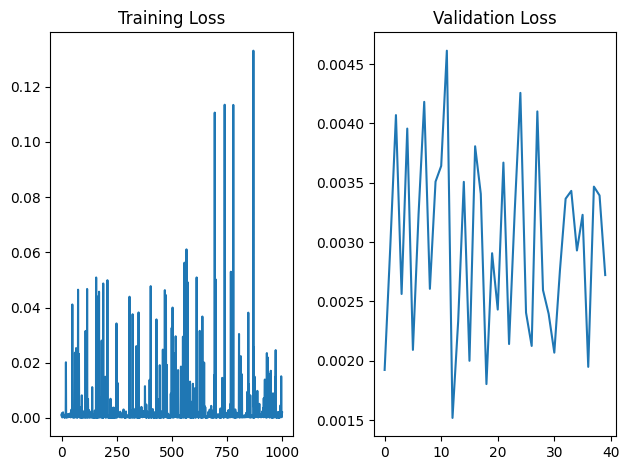



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 1000
Min_steps: 10
35/81 trainings completed



100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]


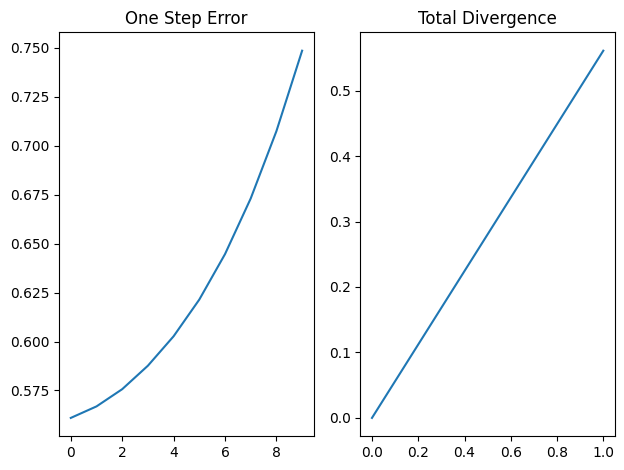

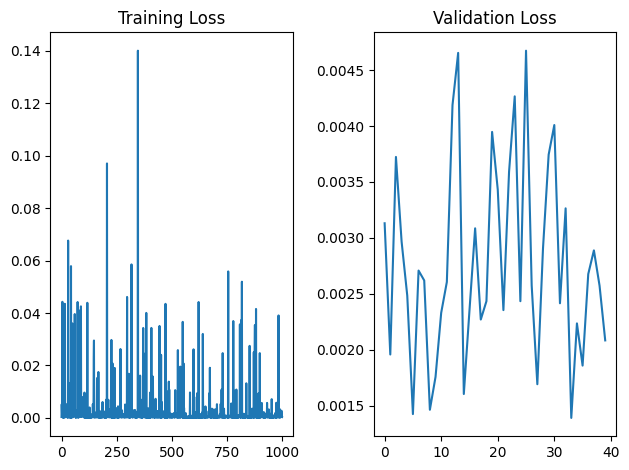



ODEFunc dimensions: [64, 64]
Noise variance: 0
Epochs: 1000
Min_steps: 18
36/81 trainings completed



100%|██████████| 1000/1000 [00:55<00:00, 17.92it/s]


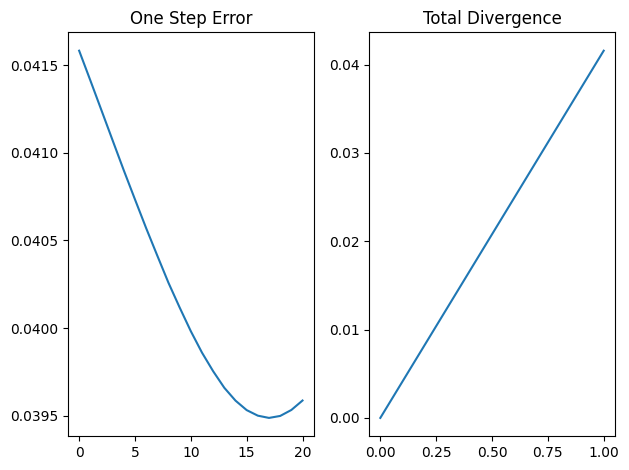

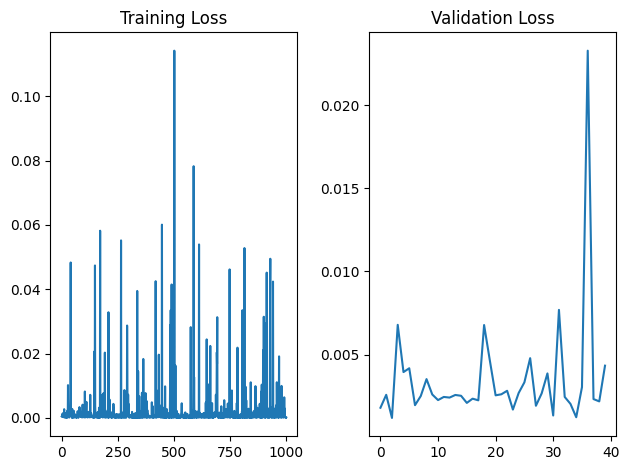



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 200
Min_steps: 3
37/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.77it/s]


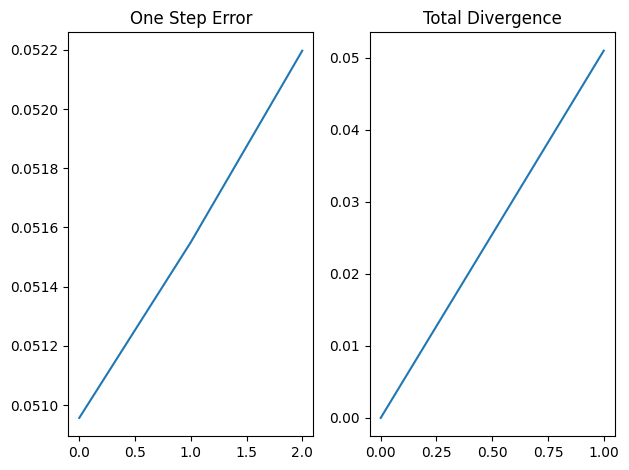

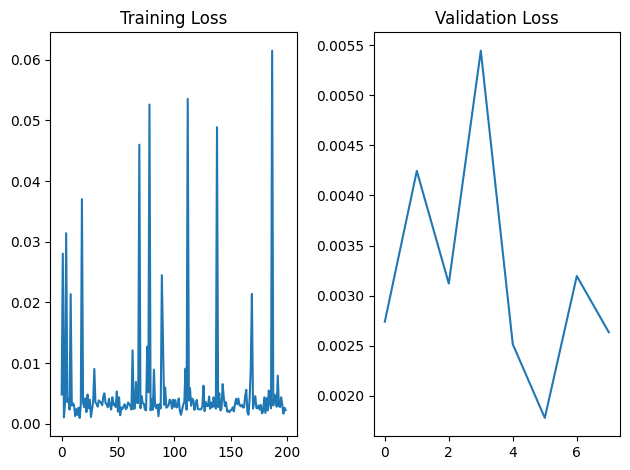



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 200
Min_steps: 10
38/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 16.70it/s]


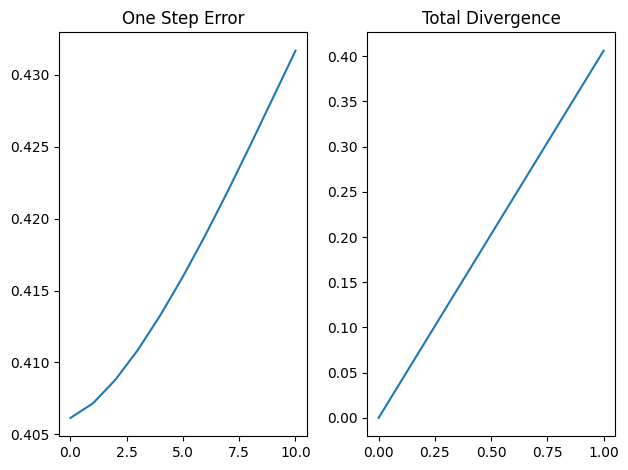

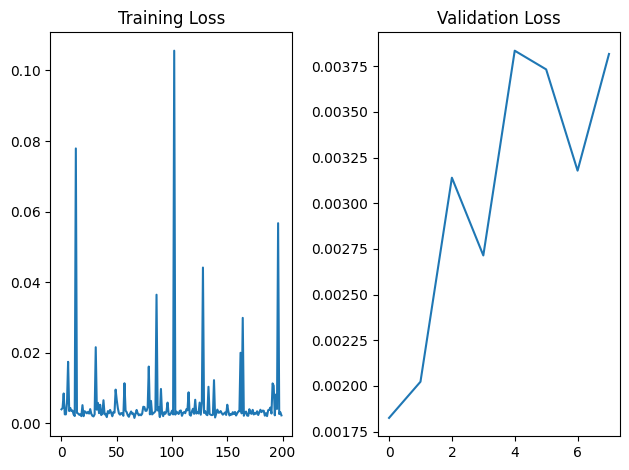



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 200
Min_steps: 18
39/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.73it/s]


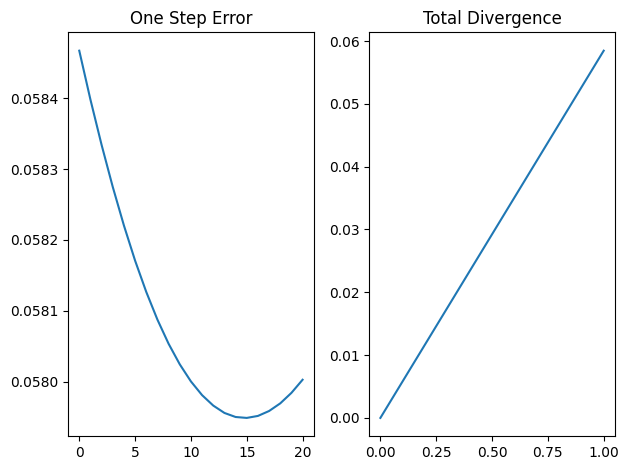

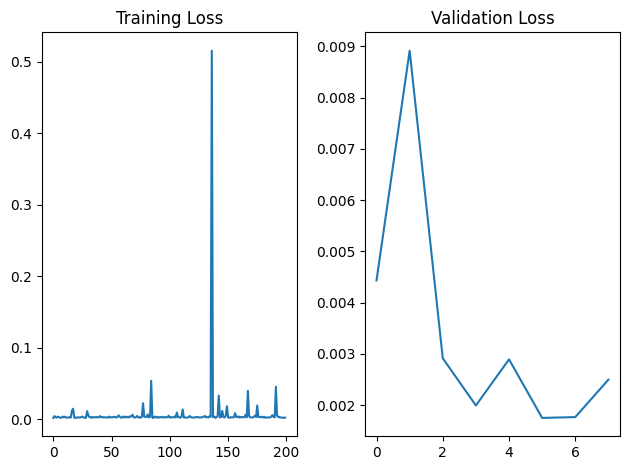



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 500
Min_steps: 3
40/81 trainings completed



100%|██████████| 500/500 [00:25<00:00, 19.27it/s]


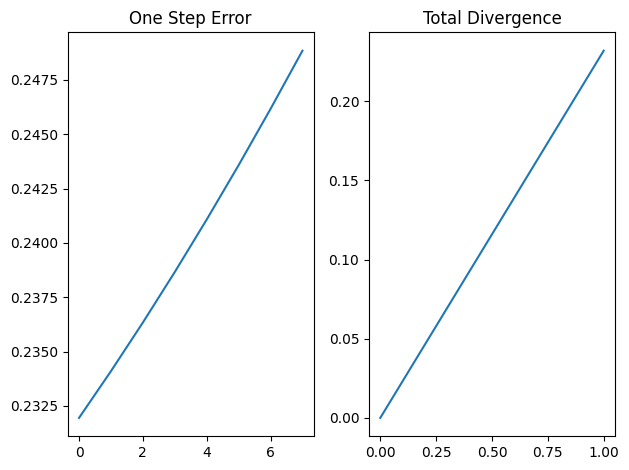

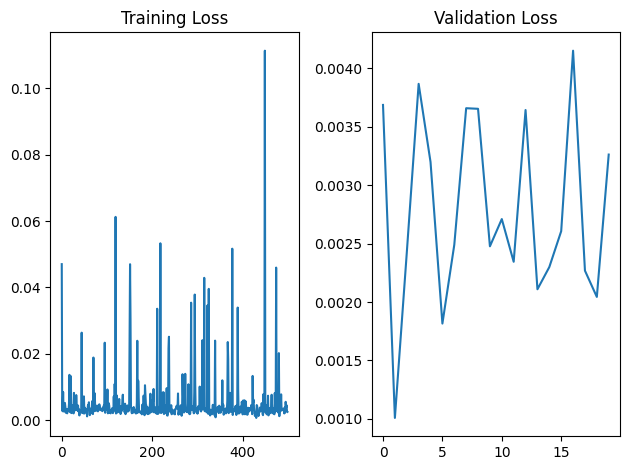



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 500
Min_steps: 10
41/81 trainings completed



100%|██████████| 500/500 [00:28<00:00, 17.62it/s]


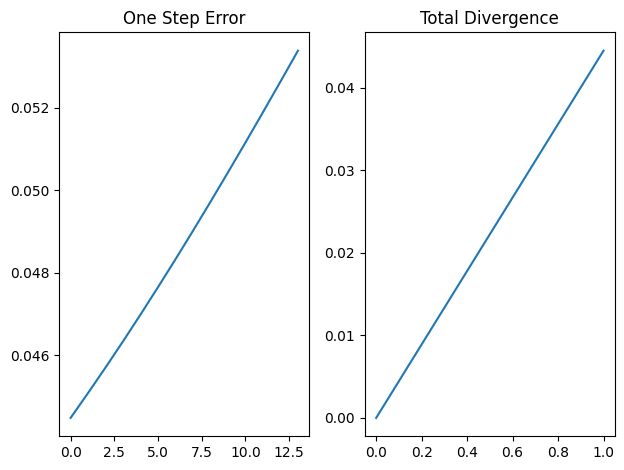

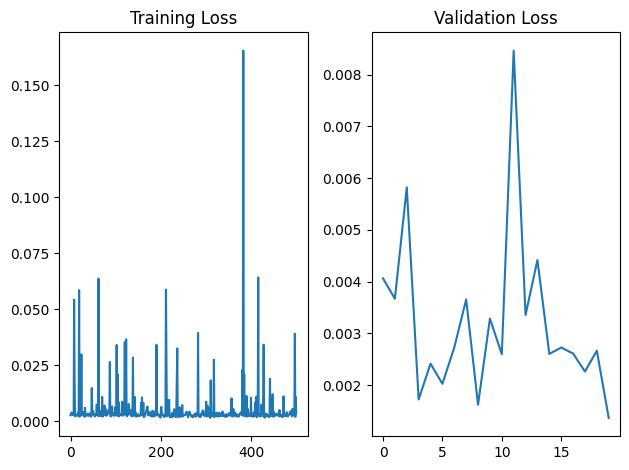



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 500
Min_steps: 18
42/81 trainings completed



100%|██████████| 500/500 [00:27<00:00, 18.40it/s]


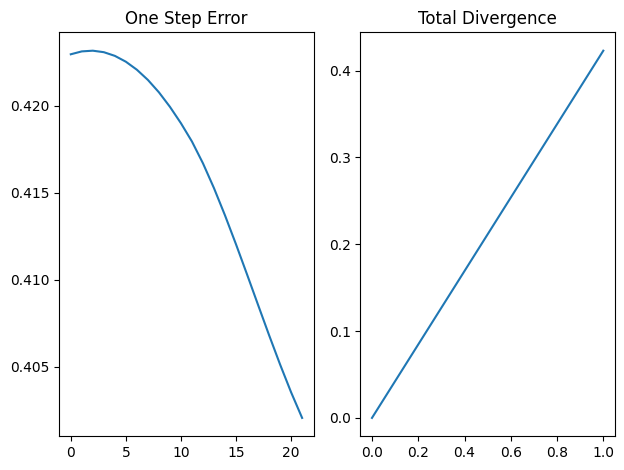

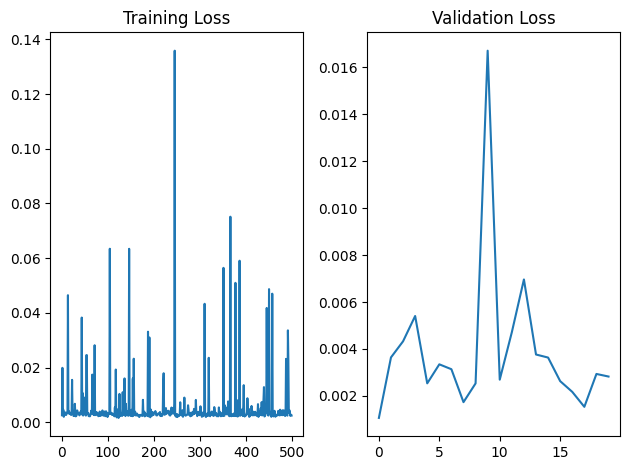



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 1000
Min_steps: 3
43/81 trainings completed



100%|██████████| 1000/1000 [00:52<00:00, 18.99it/s]


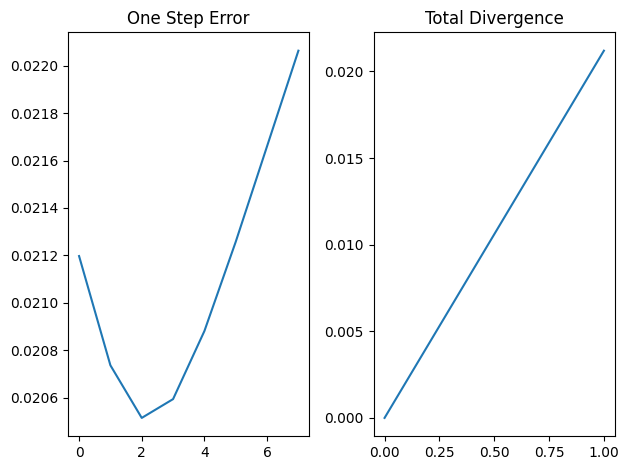

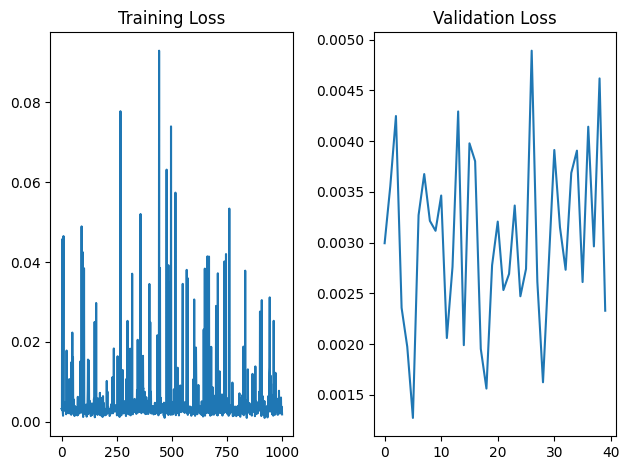



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 1000
Min_steps: 10
44/81 trainings completed



100%|██████████| 1000/1000 [00:55<00:00, 17.92it/s]


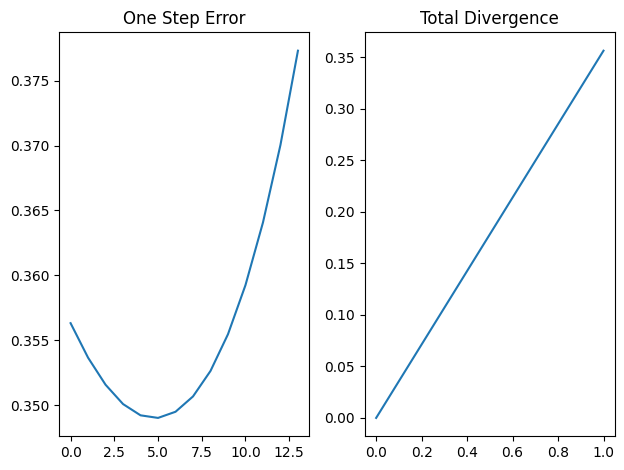

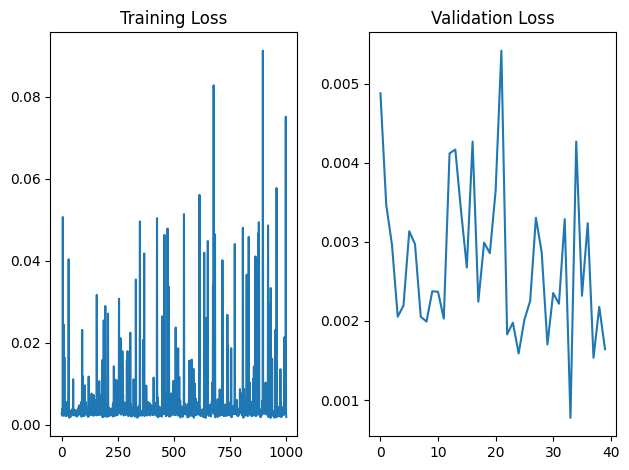



ODEFunc dimensions: [64, 64]
Noise variance: 0.05
Epochs: 1000
Min_steps: 18
45/81 trainings completed



100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


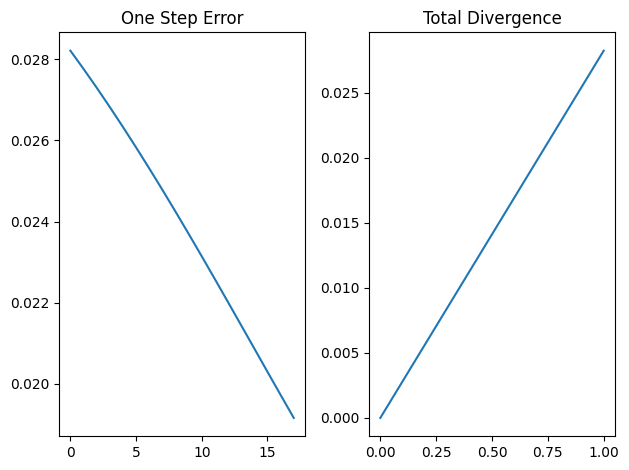

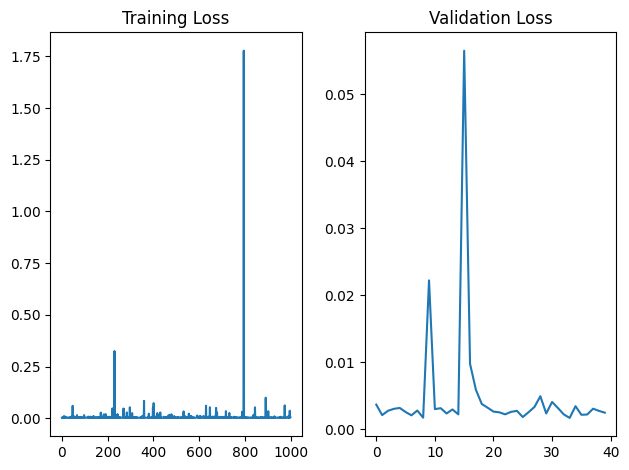



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 200
Min_steps: 3
46/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.87it/s]


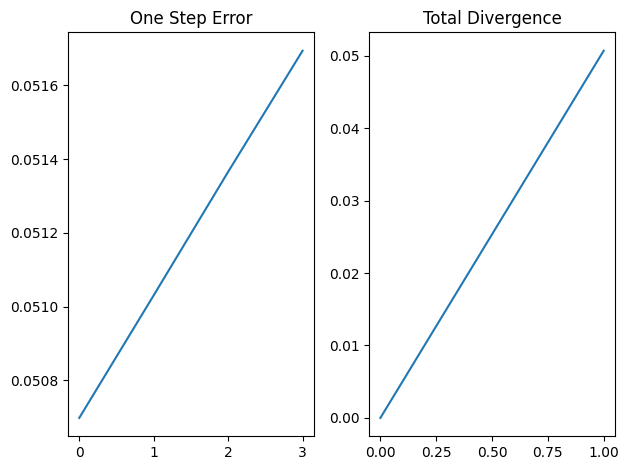

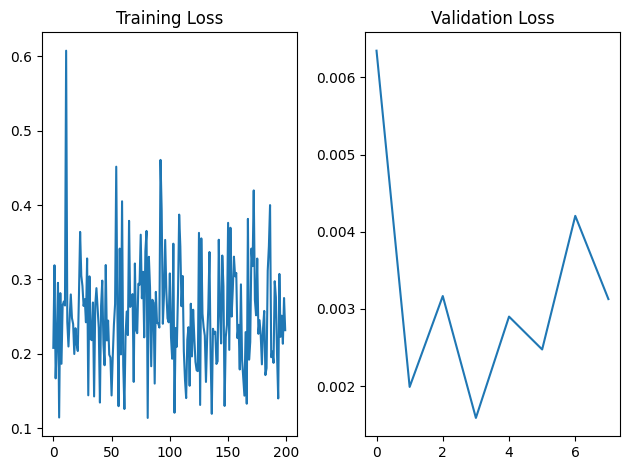



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 200
Min_steps: 10
47/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 19.30it/s]


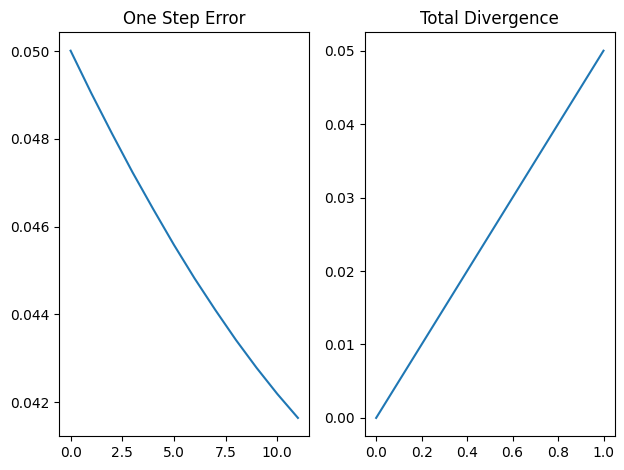

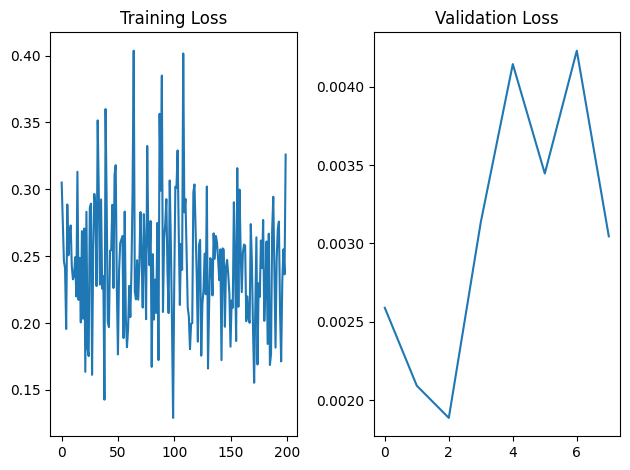



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 200
Min_steps: 18
48/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.83it/s]


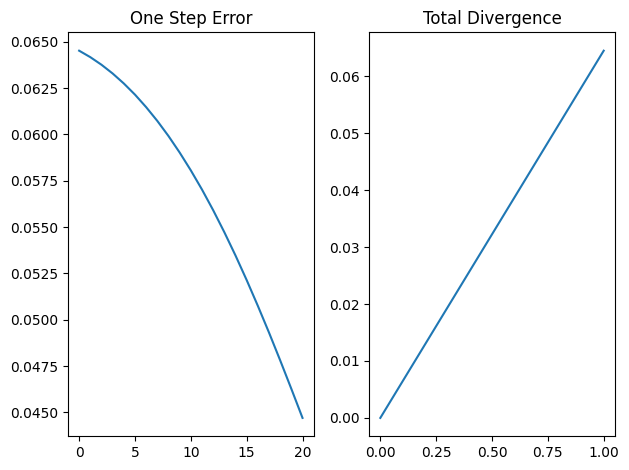

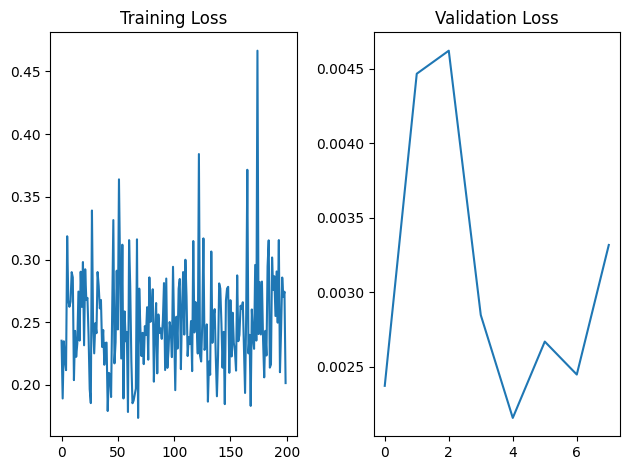



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 500
Min_steps: 3
49/81 trainings completed



100%|██████████| 500/500 [00:33<00:00, 14.97it/s]


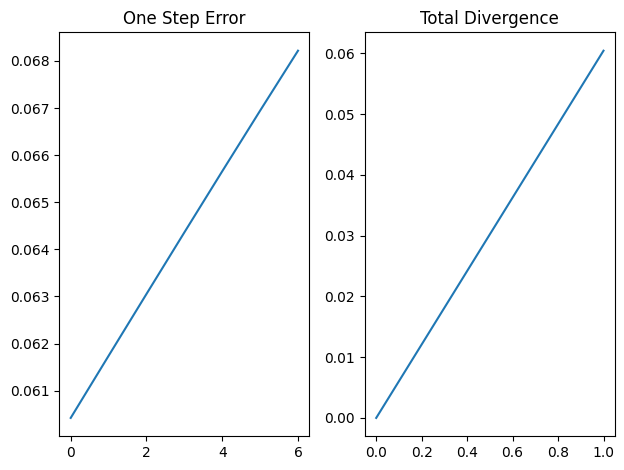

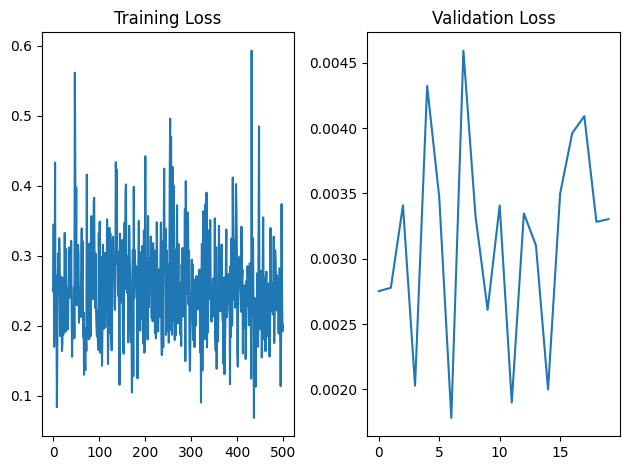



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 500
Min_steps: 10
50/81 trainings completed



100%|██████████| 500/500 [00:39<00:00, 12.68it/s]


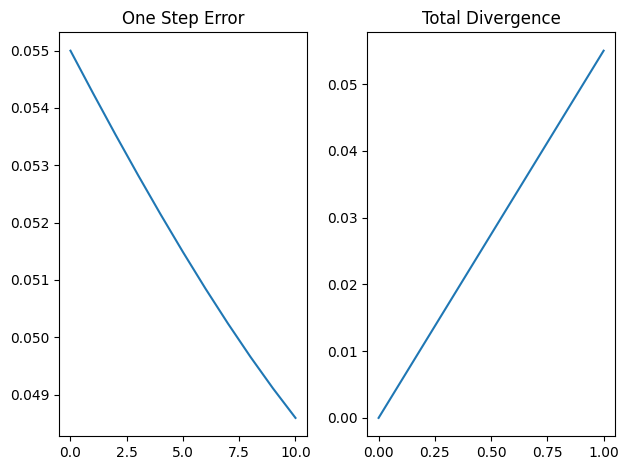

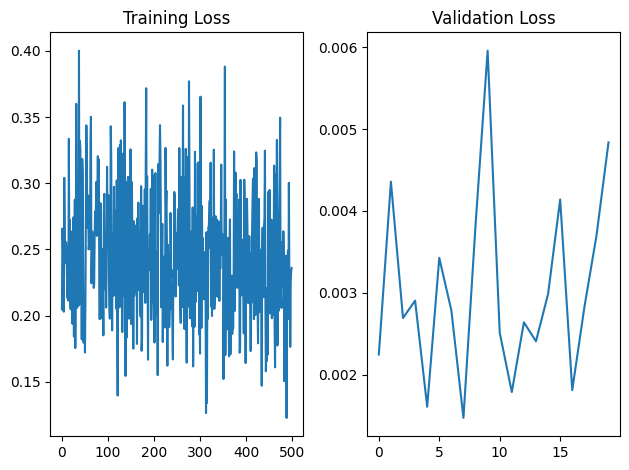



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 500
Min_steps: 18
51/81 trainings completed



100%|██████████| 500/500 [00:39<00:00, 12.60it/s]


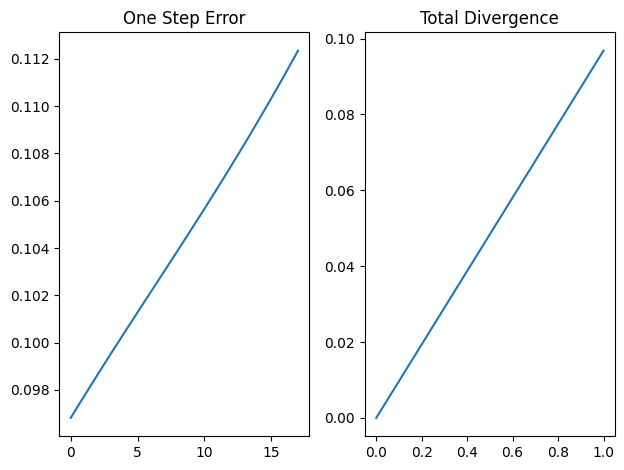

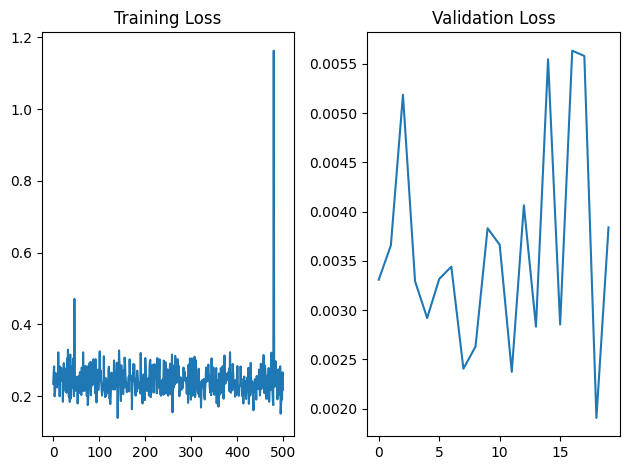



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 1000
Min_steps: 3
52/81 trainings completed



100%|██████████| 1000/1000 [01:27<00:00, 11.42it/s]


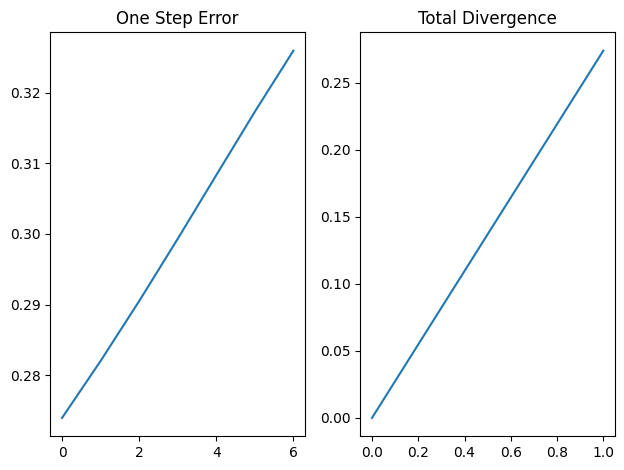

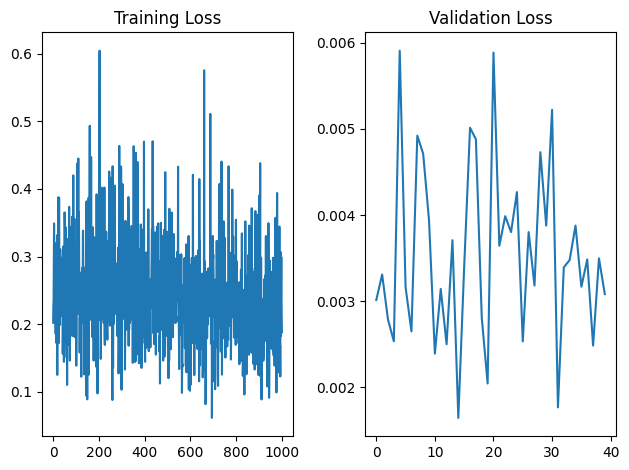



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 1000
Min_steps: 10
53/81 trainings completed



100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]


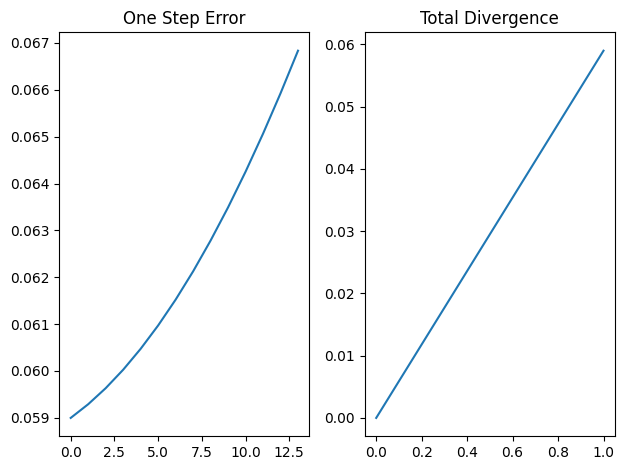

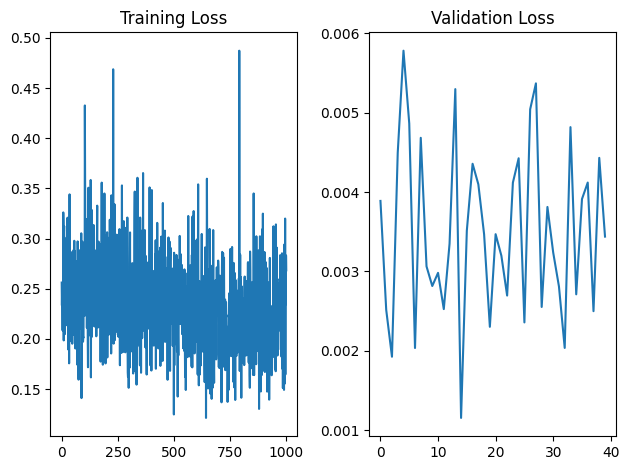



ODEFunc dimensions: [64, 64]
Noise variance: 0.5
Epochs: 1000
Min_steps: 18
54/81 trainings completed



100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


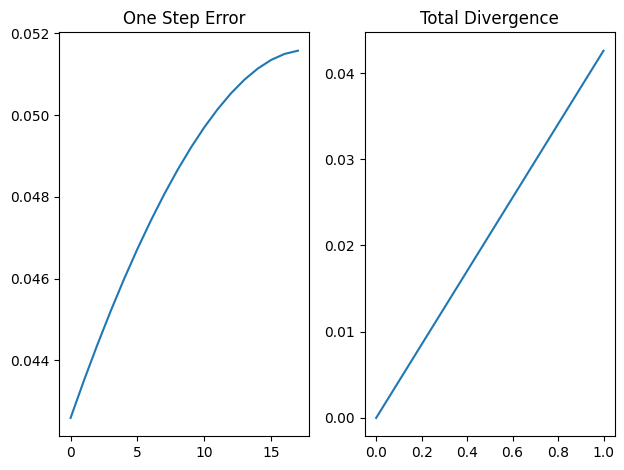

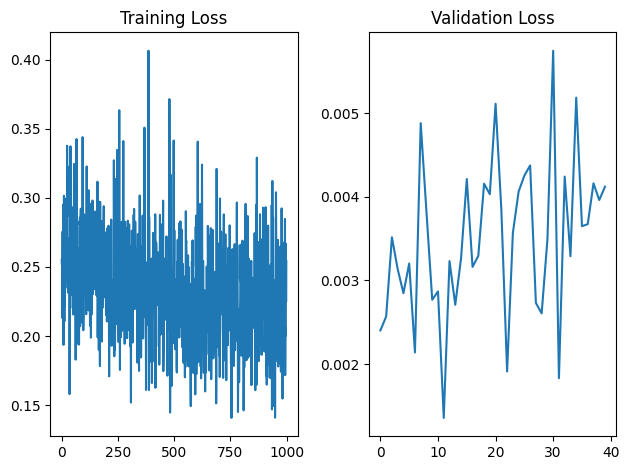



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 200
Min_steps: 3
55/81 trainings completed



100%|██████████| 200/200 [00:09<00:00, 21.98it/s]


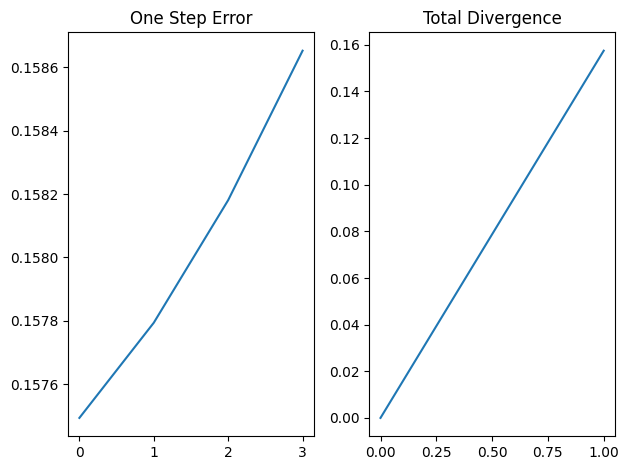

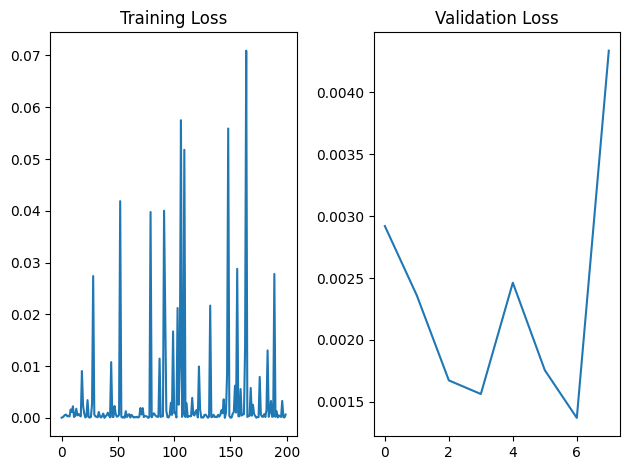



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 200
Min_steps: 10
56/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 19.77it/s]


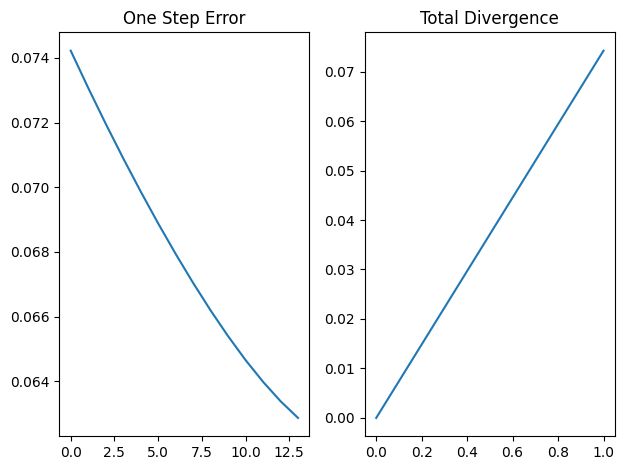

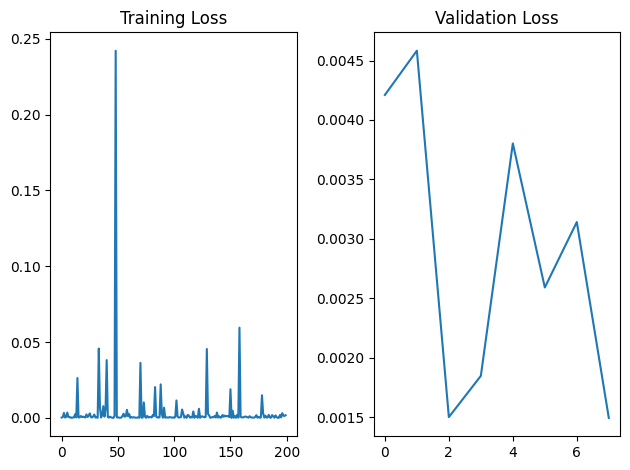



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 200
Min_steps: 18
57/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 19.32it/s]


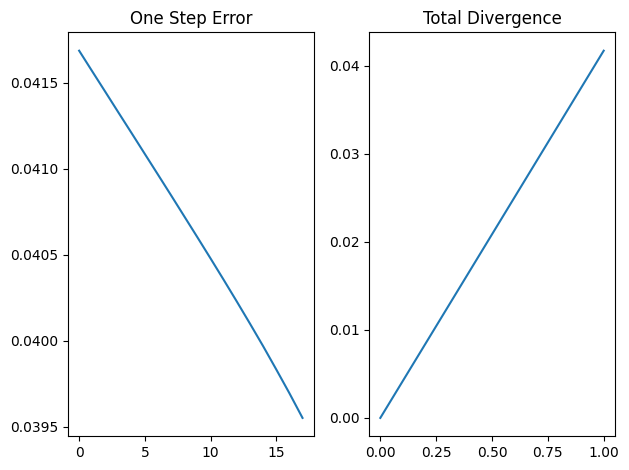

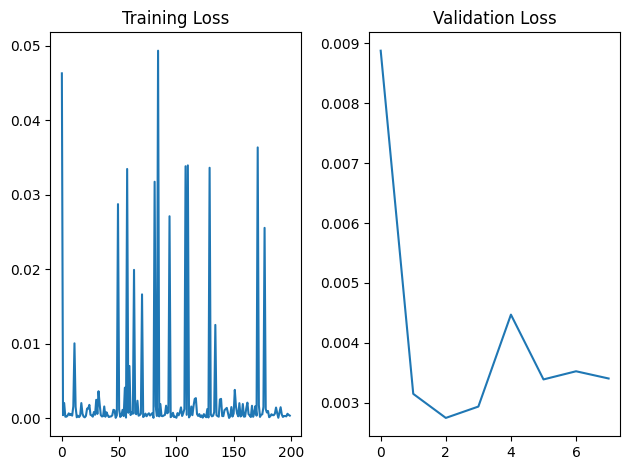



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 500
Min_steps: 3
58/81 trainings completed



100%|██████████| 500/500 [00:23<00:00, 21.45it/s]


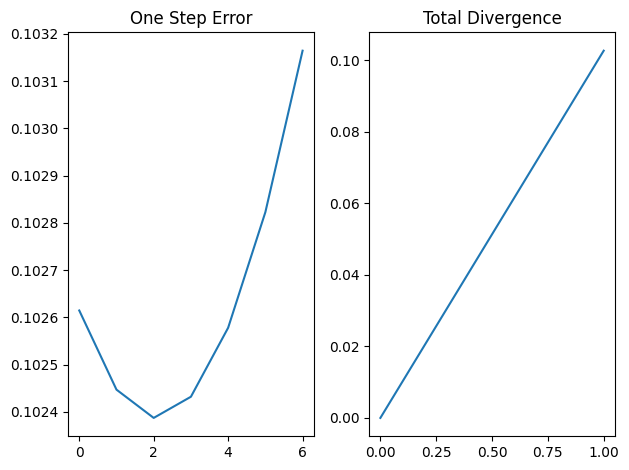

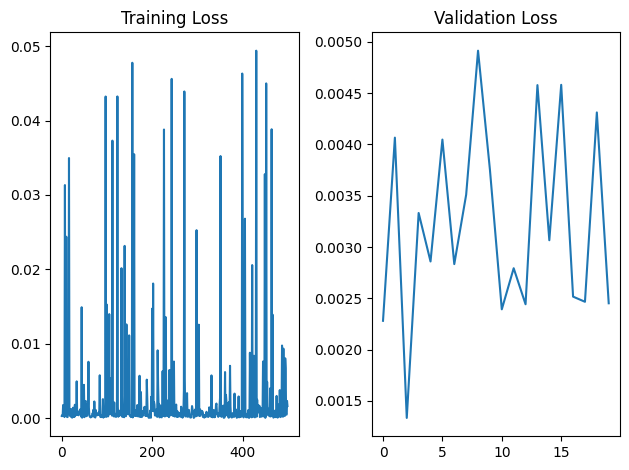



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 500
Min_steps: 10
59/81 trainings completed



100%|██████████| 500/500 [00:25<00:00, 19.85it/s]


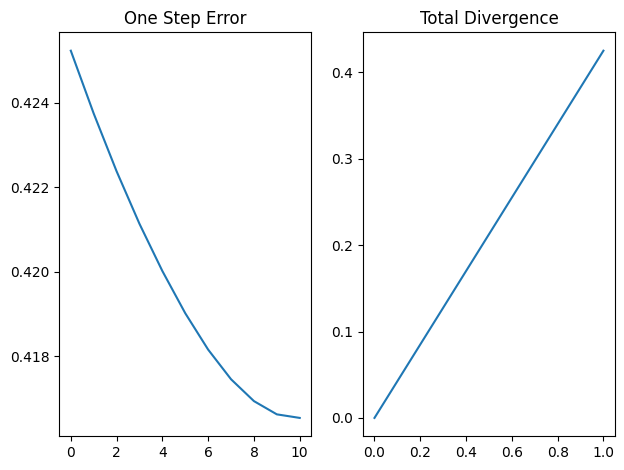

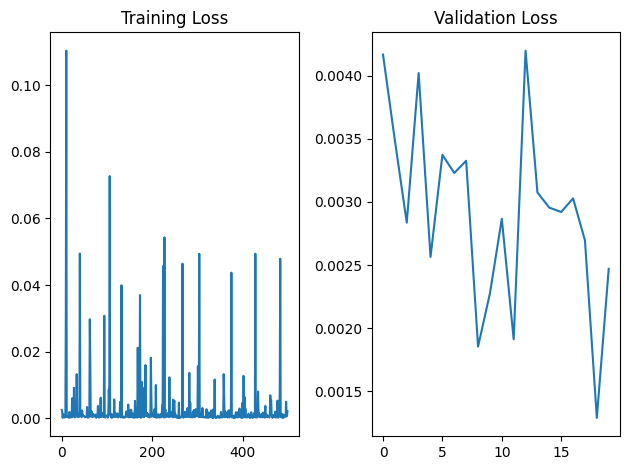



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 500
Min_steps: 18
60/81 trainings completed



100%|██████████| 500/500 [00:26<00:00, 19.14it/s]


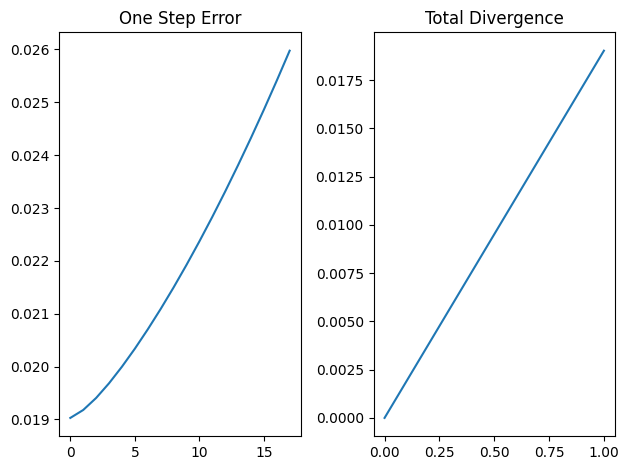

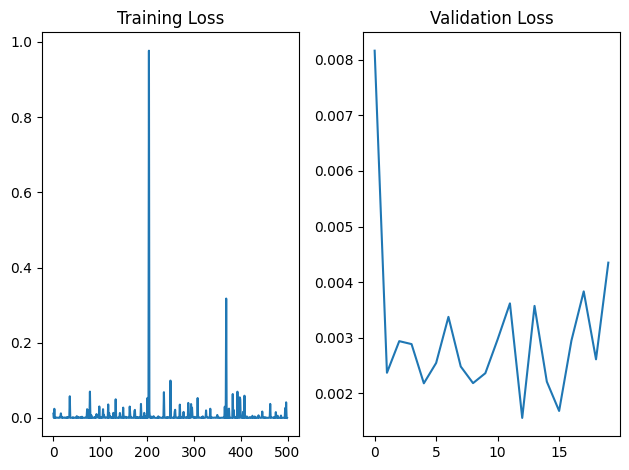



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 1000
Min_steps: 3
61/81 trainings completed



100%|██████████| 1000/1000 [00:49<00:00, 20.10it/s]


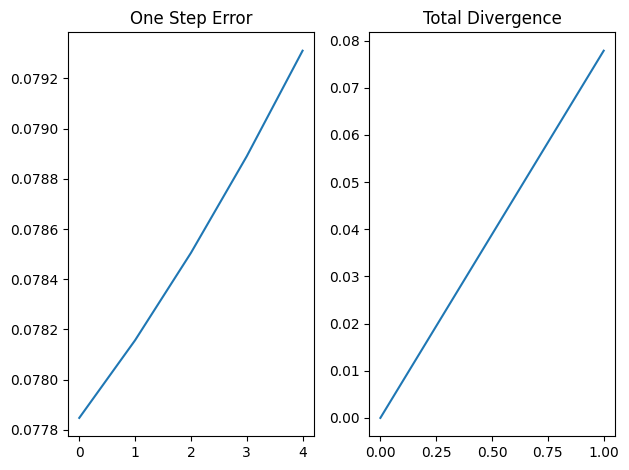

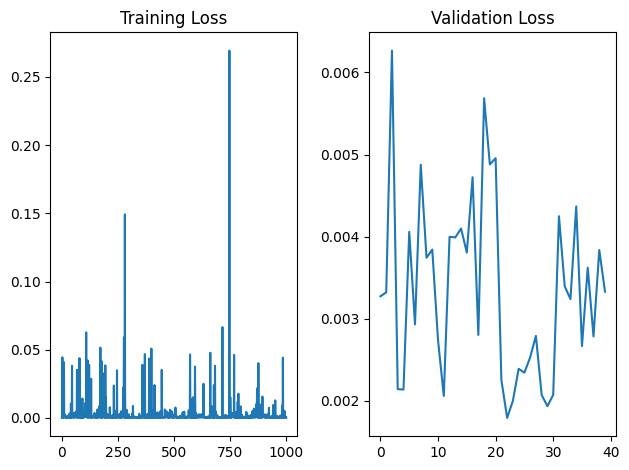



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 1000
Min_steps: 10
62/81 trainings completed



100%|██████████| 1000/1000 [00:50<00:00, 19.85it/s]


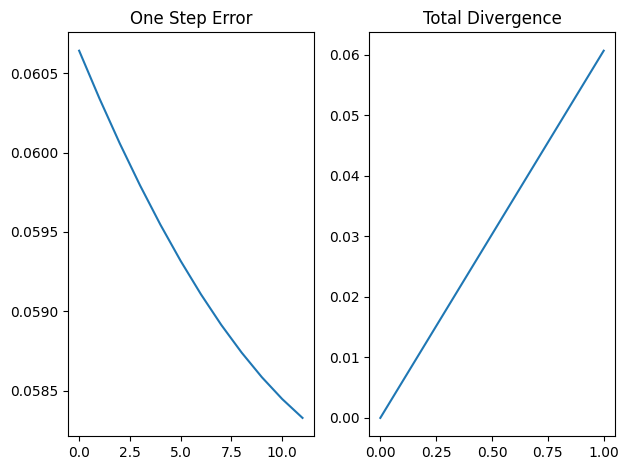

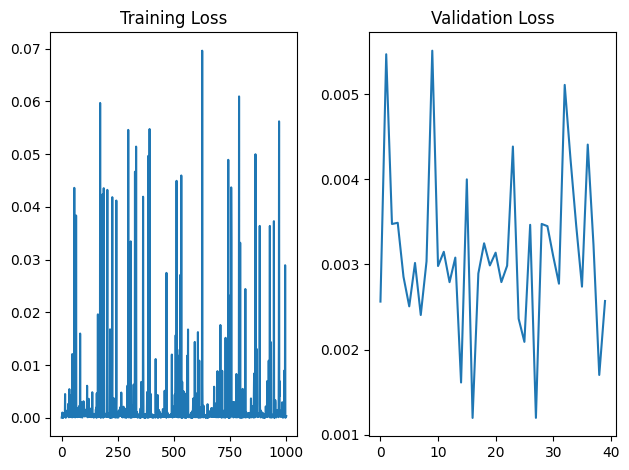



ODEFunc dimensions: [32]
Noise variance: 0
Epochs: 1000
Min_steps: 18
63/81 trainings completed



100%|██████████| 1000/1000 [00:52<00:00, 19.09it/s]


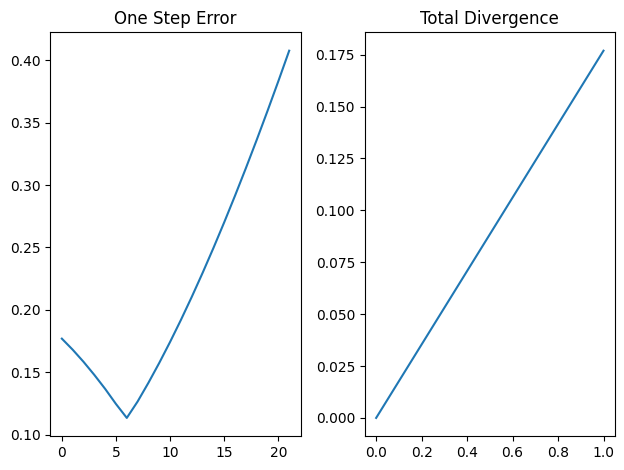

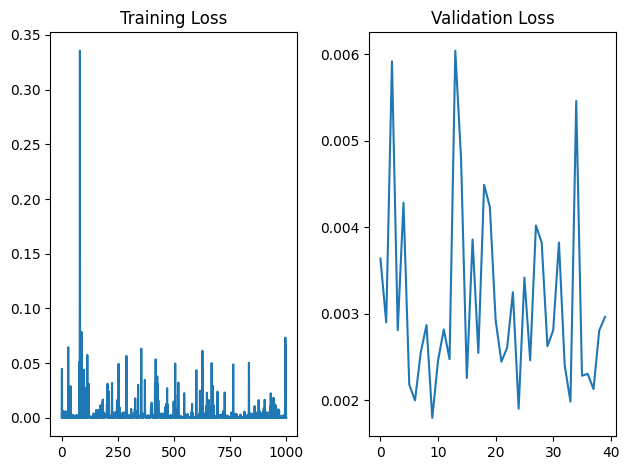



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 200
Min_steps: 3
64/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 19.99it/s]


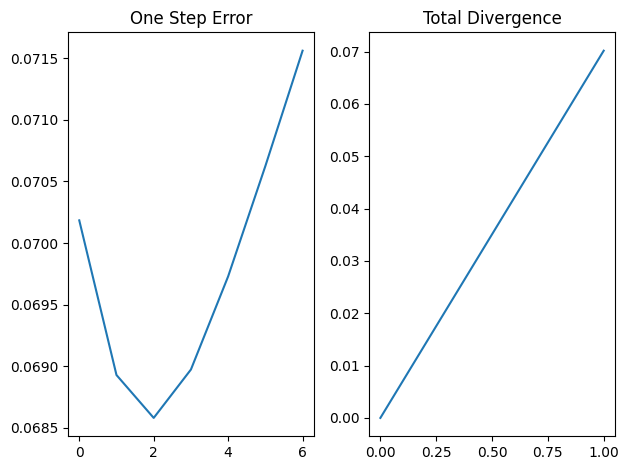

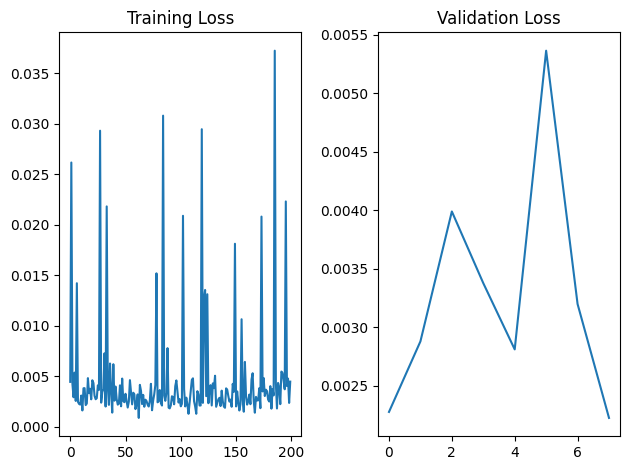



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 200
Min_steps: 10
65/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.64it/s]


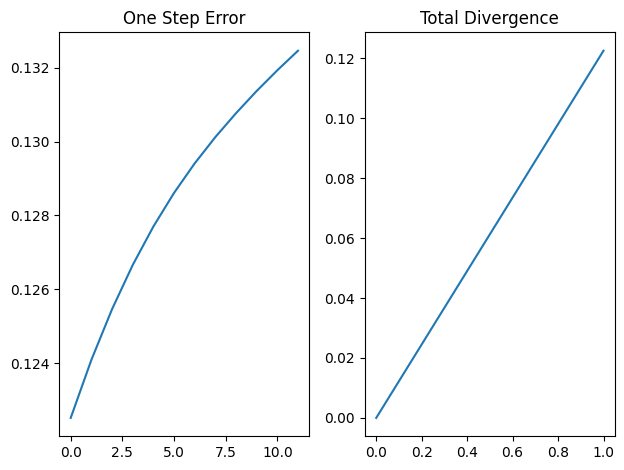

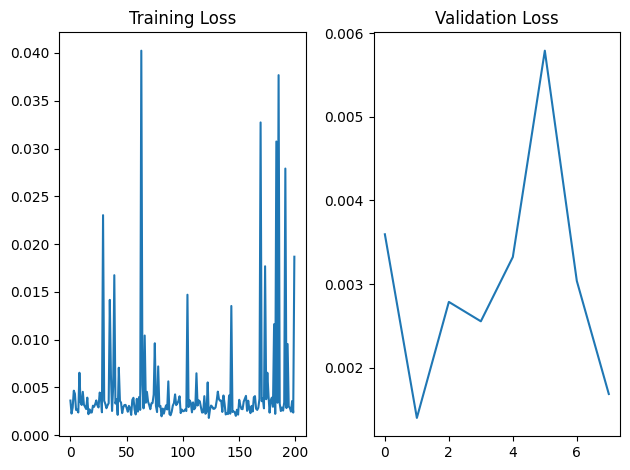



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 200
Min_steps: 18
66/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.85it/s]


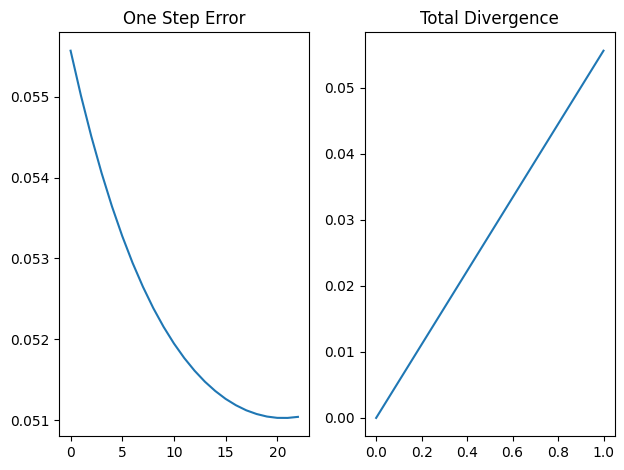

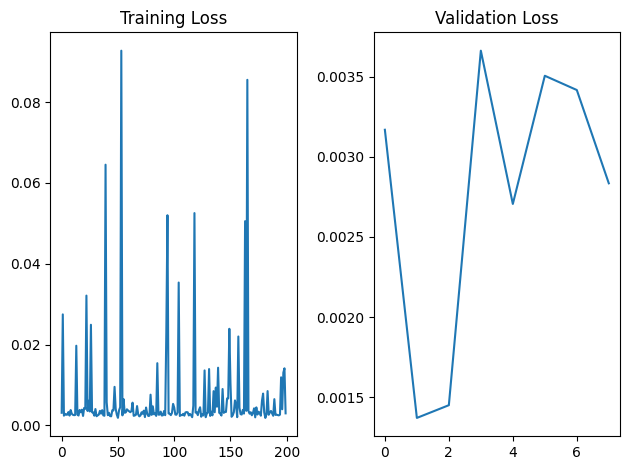



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 500
Min_steps: 3
67/81 trainings completed



100%|██████████| 500/500 [00:23<00:00, 20.94it/s]


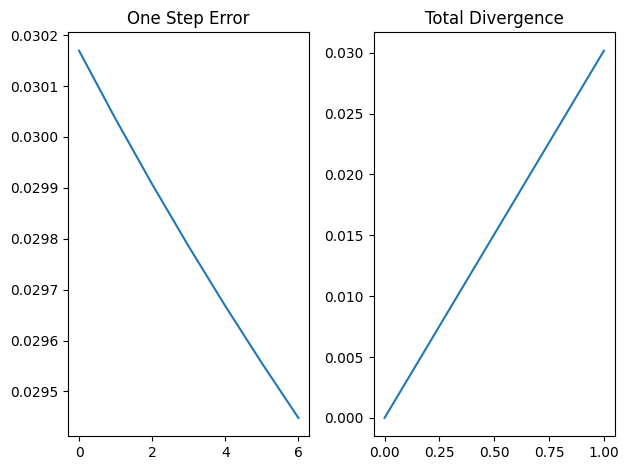

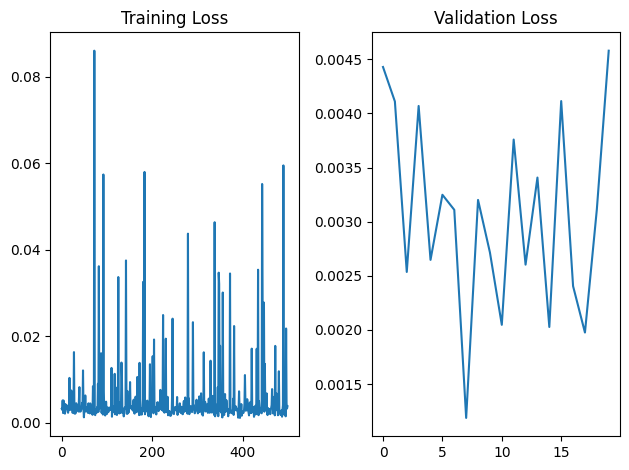



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 500
Min_steps: 10
68/81 trainings completed



100%|██████████| 500/500 [00:25<00:00, 19.94it/s]


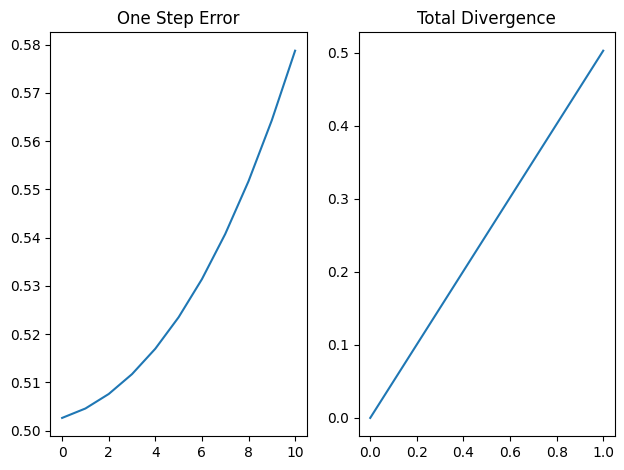

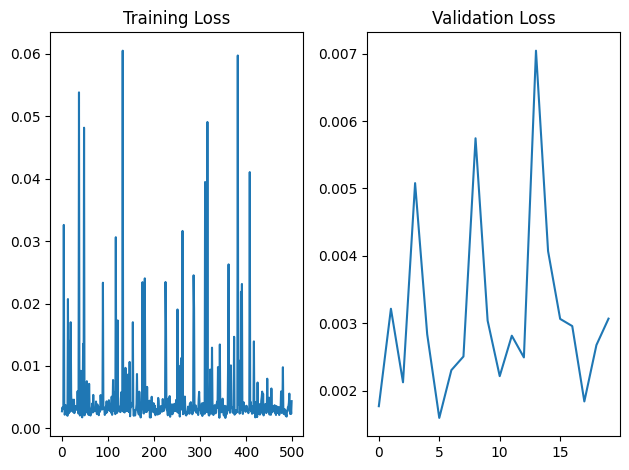



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 500
Min_steps: 18
69/81 trainings completed



100%|██████████| 500/500 [00:26<00:00, 18.98it/s]


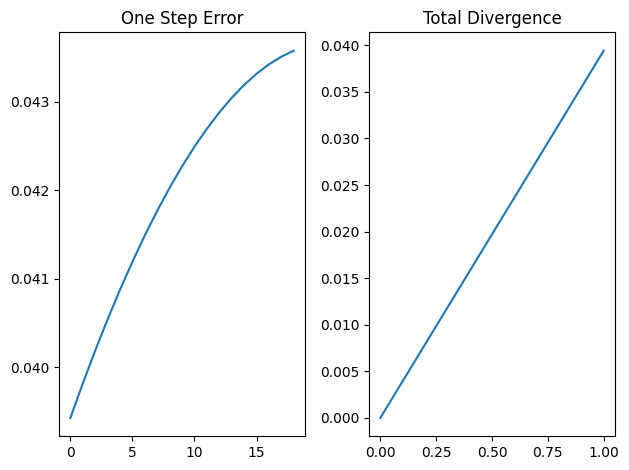

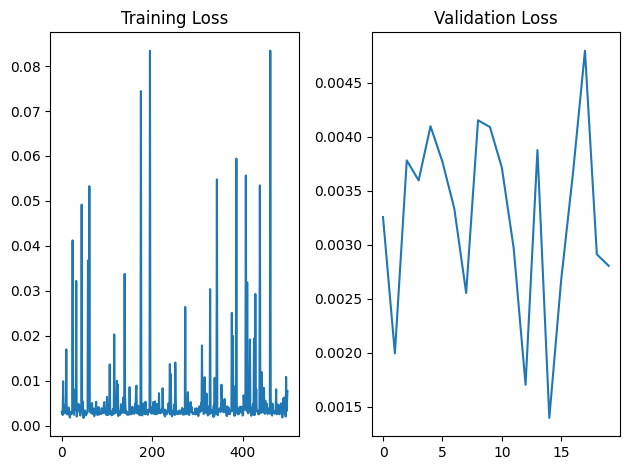



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 1000
Min_steps: 3
70/81 trainings completed



100%|██████████| 1000/1000 [00:51<00:00, 19.45it/s]


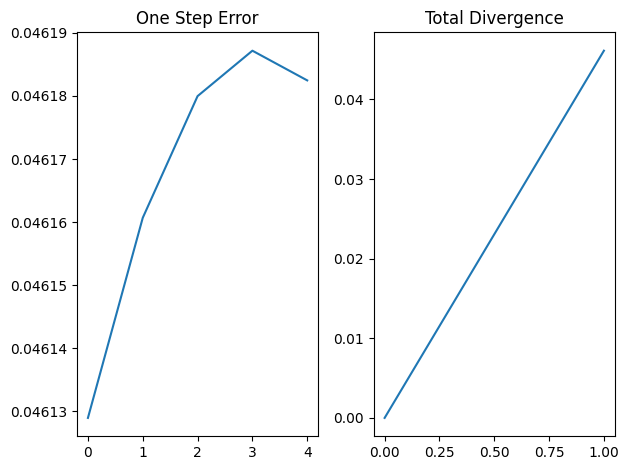

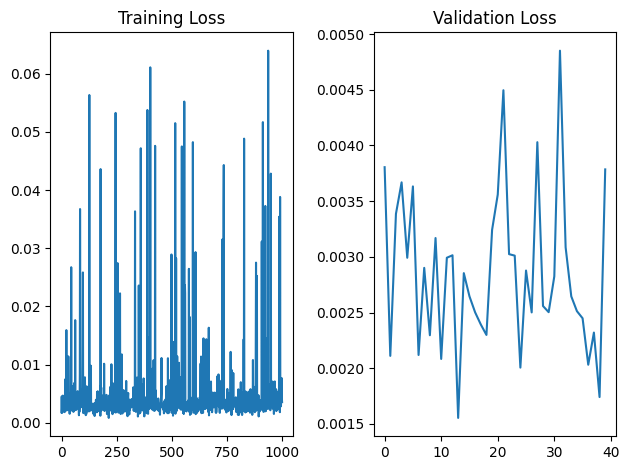



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 1000
Min_steps: 10
71/81 trainings completed



100%|██████████| 1000/1000 [00:52<00:00, 19.15it/s]


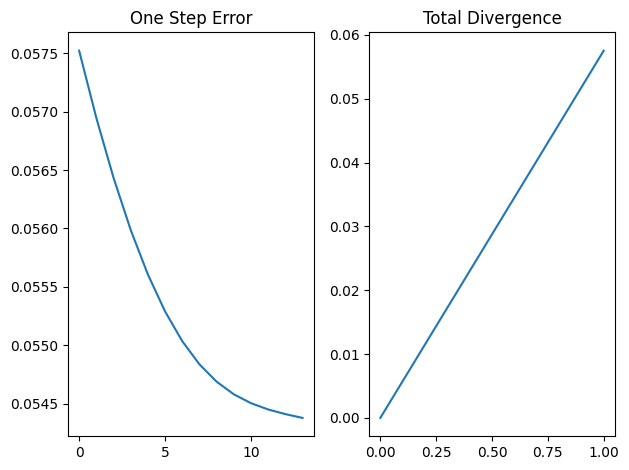

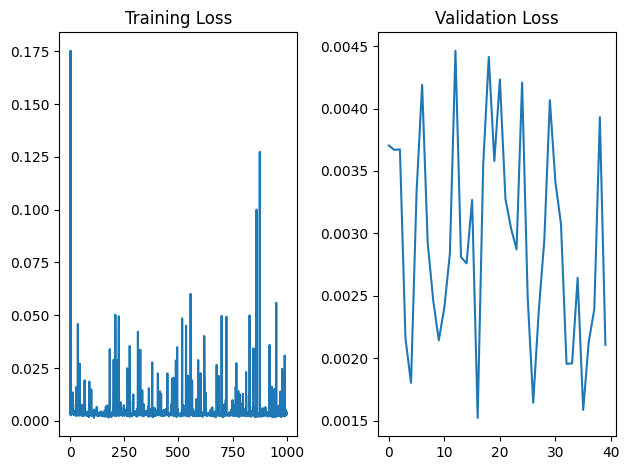



ODEFunc dimensions: [32]
Noise variance: 0.05
Epochs: 1000
Min_steps: 18
72/81 trainings completed



100%|██████████| 1000/1000 [00:52<00:00, 19.07it/s]


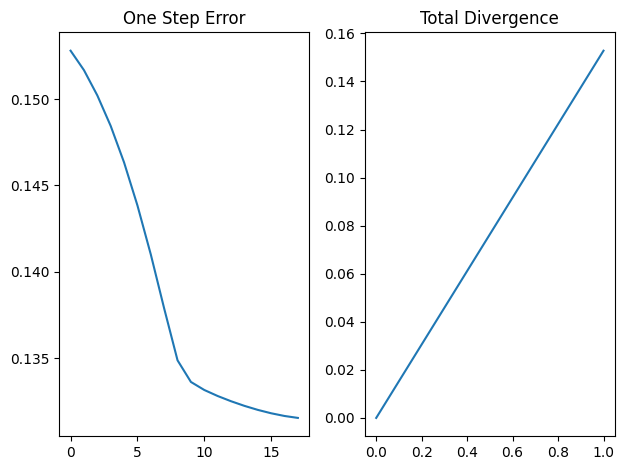

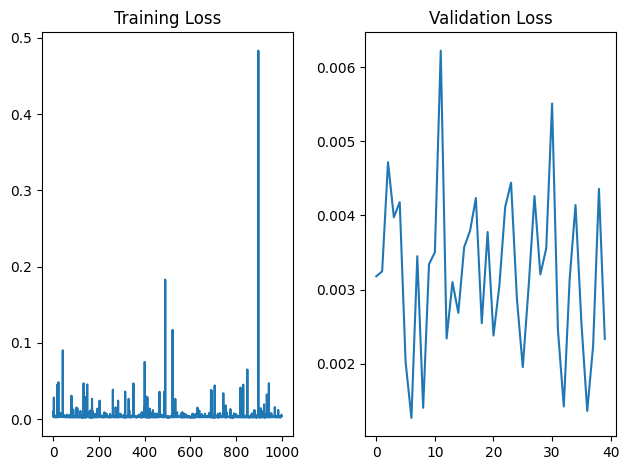



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 200
Min_steps: 3
73/81 trainings completed



100%|██████████| 200/200 [00:10<00:00, 18.62it/s]


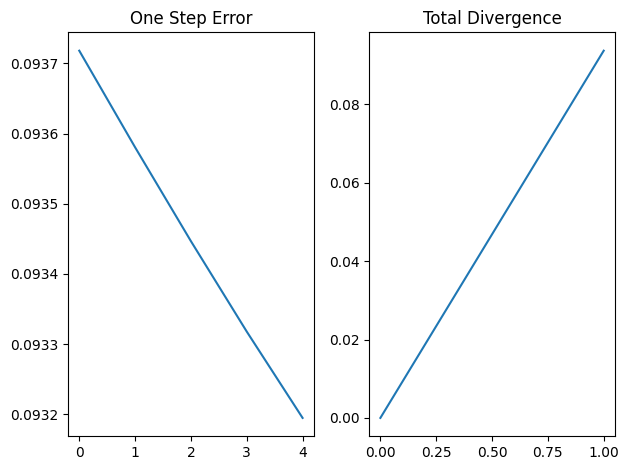

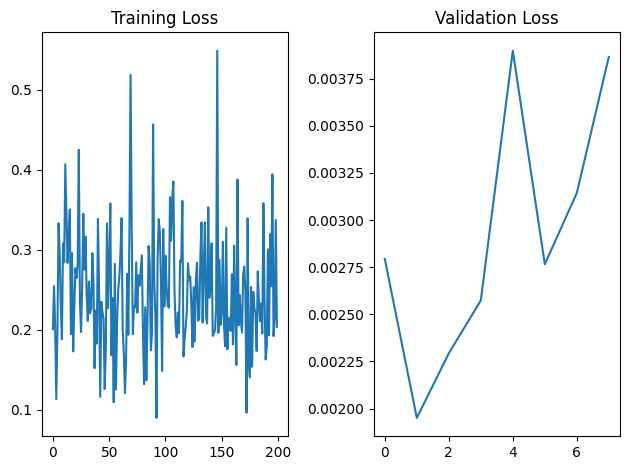



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 200
Min_steps: 10
74/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.86it/s]


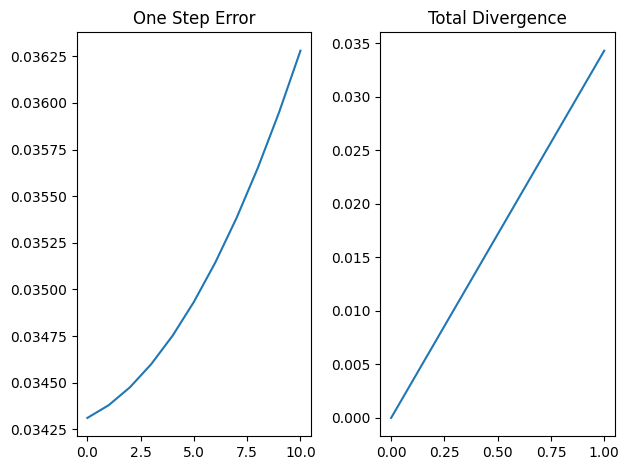

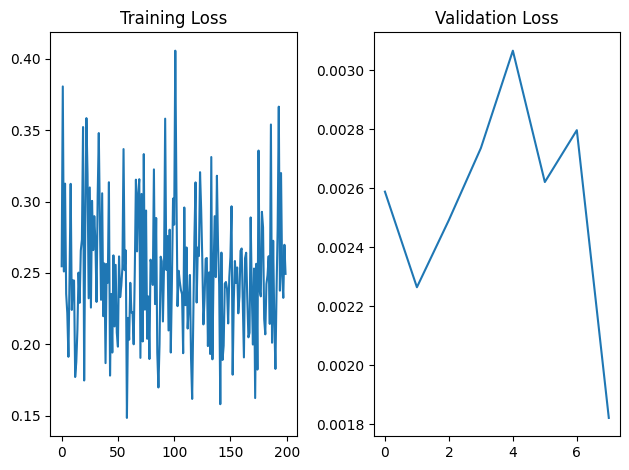



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 200
Min_steps: 18
75/81 trainings completed



100%|██████████| 200/200 [00:11<00:00, 17.60it/s]


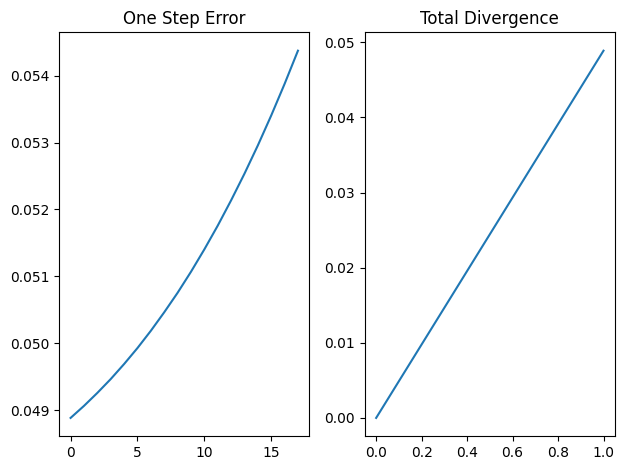

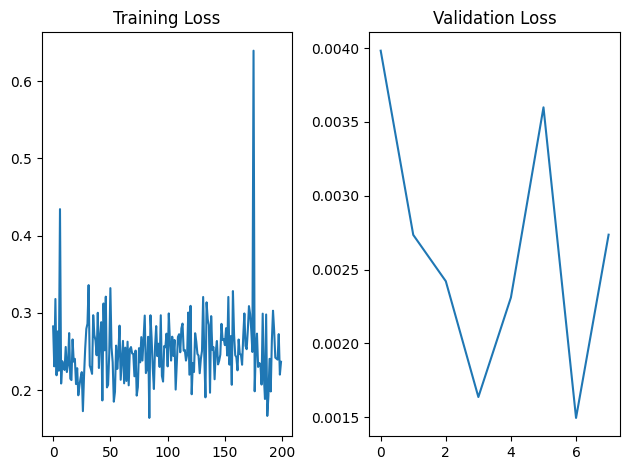



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 500
Min_steps: 3
76/81 trainings completed



100%|██████████| 500/500 [00:25<00:00, 19.75it/s]


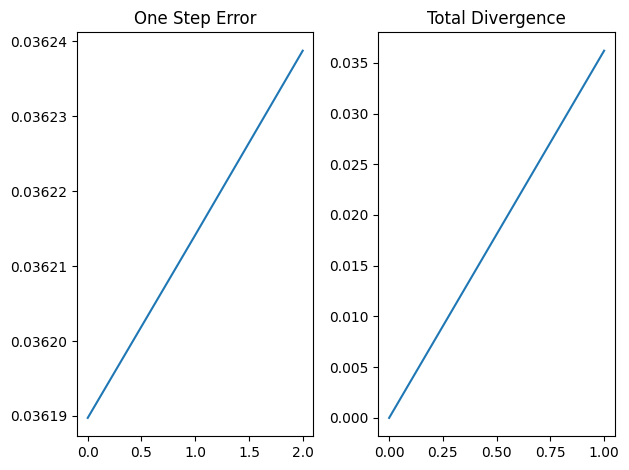

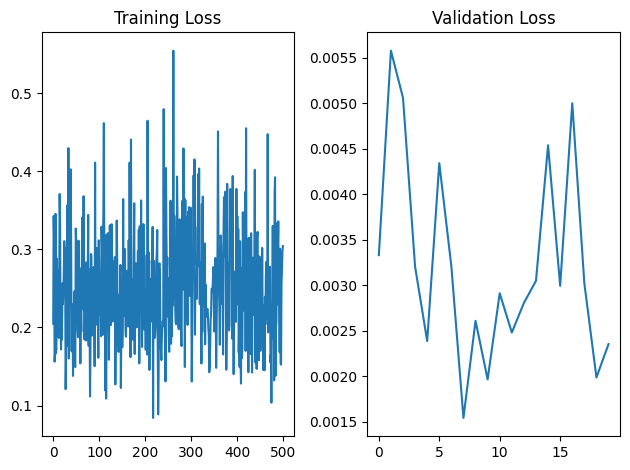



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 500
Min_steps: 10
77/81 trainings completed



100%|██████████| 500/500 [00:28<00:00, 17.31it/s]


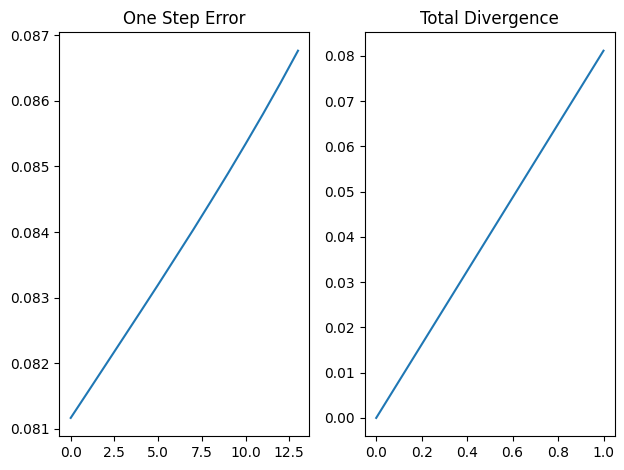

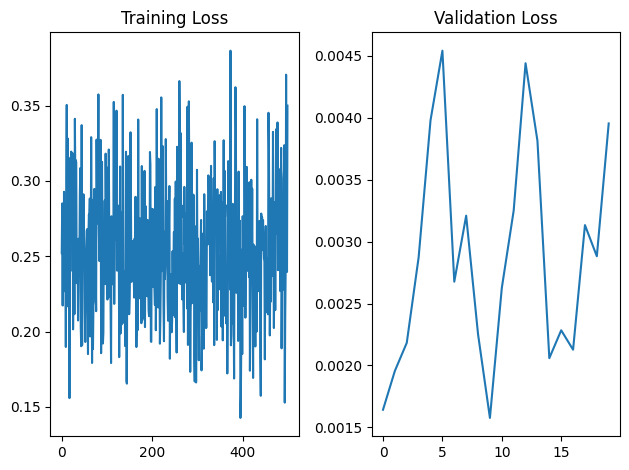



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 500
Min_steps: 18
78/81 trainings completed



100%|██████████| 500/500 [00:27<00:00, 18.10it/s]


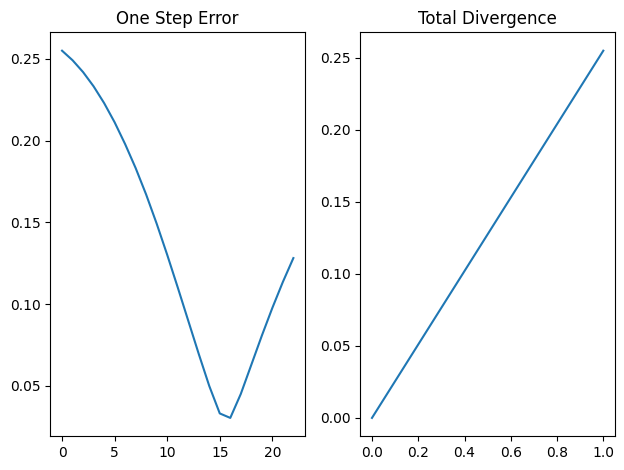

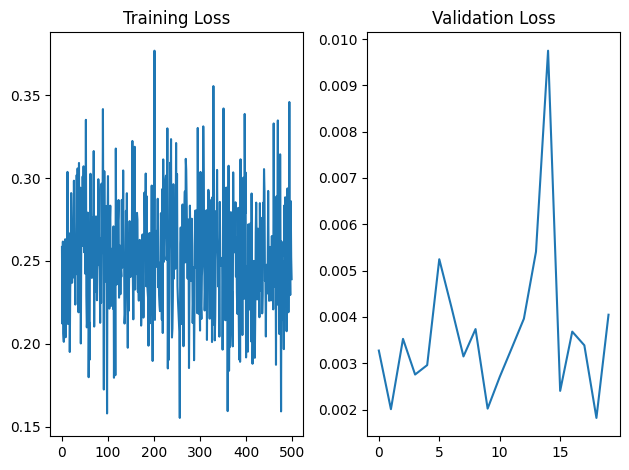



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 1000
Min_steps: 3
79/81 trainings completed



100%|██████████| 1000/1000 [00:52<00:00, 19.20it/s]


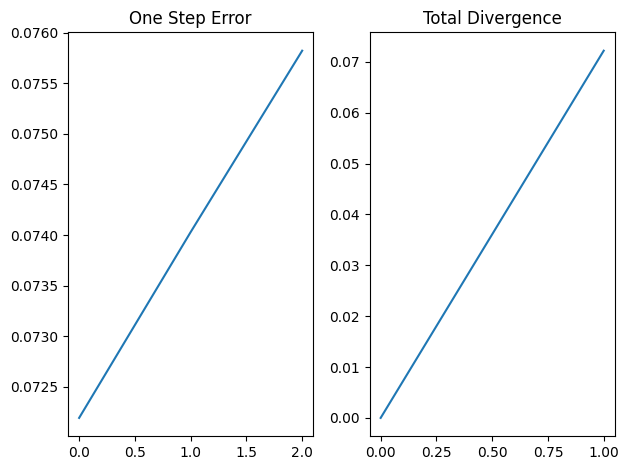

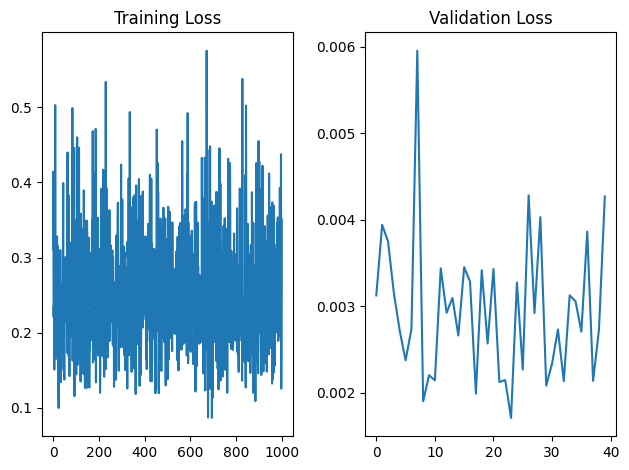



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 1000
Min_steps: 10
80/81 trainings completed



100%|██████████| 1000/1000 [00:58<00:00, 17.24it/s]


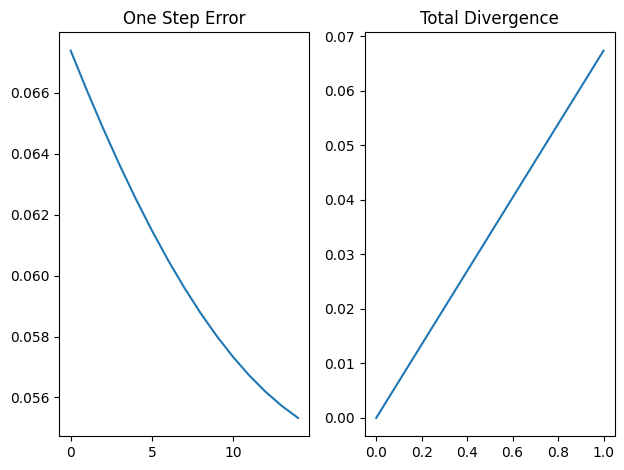

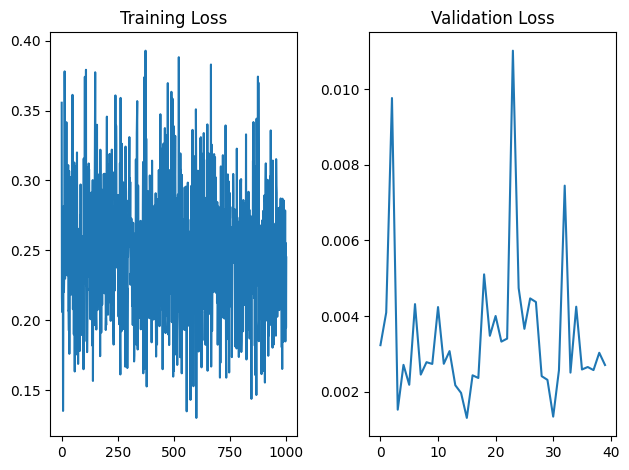



ODEFunc dimensions: [32]
Noise variance: 0.5
Epochs: 1000
Min_steps: 18
81/81 trainings completed



100%|██████████| 1000/1000 [01:04<00:00, 15.58it/s]


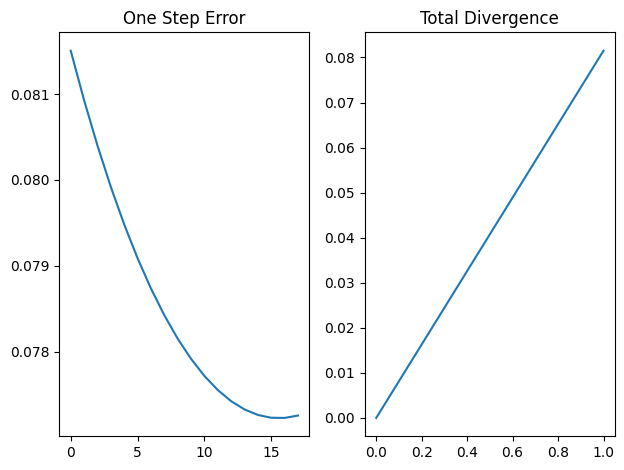

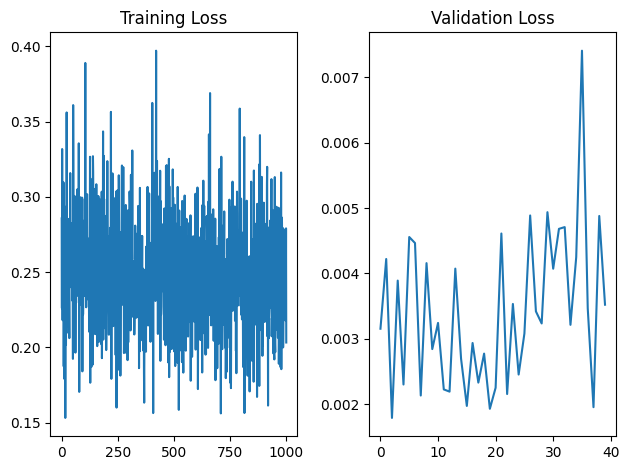

In [ ]:
num_trainings = 0
total_trainings = len(epochs) * len(dim_sets) * len(noise) * len(steps)
for dims in dim_sets:

    for std_dev in noise:

        for num_epochs in epochs:

            for min_steps in steps:
                print("\n\nODEFunc dimensions:", dims)
                print("Noise variance:", std_dev)
                print("Epochs:", num_epochs)
                print("Min_steps:", min_steps)
                num_trainings += 1
                print(f"{num_trainings}/{total_trainings} trainings completed\n")

                train_losses, val_losses = train_model(num_epochs, dims, std_dev, min_steps, num_trainings)

                plt.subplot(121)
                plt.plot(train_losses)
                plt.title("Training Loss")

                plt.subplot(122)
                plt.plot(val_losses)
                plt.title("Validation Loss")

                plt.tight_layout()
                plt.show()

In [ ]:
!zip -r /content/Ablation_models.zip /content/Ablation_models

  adding: content/Ablation_models/ (stored 0%)
  adding: content/Ablation_models/model_23_TD.pt (deflated 56%)
  adding: content/Ablation_models/model_36_OSE.pt (deflated 50%)
  adding: content/Ablation_models/model_15_OSE.pt (deflated 50%)
  adding: content/Ablation_models/model_37_OSE.pt (deflated 53%)
  adding: content/Ablation_models/model_44_TD.pt (deflated 55%)
  adding: content/Ablation_models/model_81.pt (deflated 37%)
  adding: content/Ablation_models/model_70_TD.pt (deflated 56%)
  adding: content/Ablation_models/model_65.pt (deflated 37%)
  adding: content/Ablation_models/model_2_OSE.pt (deflated 51%)
  adding: content/Ablation_models/model_64_train_losses.pt (deflated 61%)
  adding: content/Ablation_models/model_48_val_losses.pt (deflated 49%)
  adding: content/Ablation_models/model_50_val_losses.pt (deflated 47%)
  adding: content/Ablation_models/model_78_TD.pt (deflated 56%)
  adding: content/Ablation_models/model_43_train_losses.pt (deflated 64%)
  adding: content/Ablati

In [ ]:
from google.colab import files
files.download("/content/Ablation_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Heatmaps

In [48]:
!unzip Ablation_models.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [59]:
model_num = 1
metric_arrays = np.zeros((3,9,9))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for d, dims in enumerate(dim_sets):
    for n, std_dev in enumerate(noise):
        for e, num_epochs in enumerate(epochs):
            for s, min_steps in enumerate(steps):
                data = Pendulum_Data(min_steps, min_steps+5, 9.81, 0.005, 1)
                dl = DataLoader(data, batch_size=1, shuffle=False)

                model = ODEFunc(dims)
                model = model.to(device=device)
                model.load_state_dict(torch.load(f'content/Ablation_models/model_{model_num}.pt', weights_only=True))
                model.eval()

                for X_batch, y_batch in dl:
                    X_batch += np.random.normal(0, std_dev, X_batch.shape)
                    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
                    y_pred = odeint(model, X_batch[:, :, 4:], 0.005 * torch.arange(len(X_batch)+1))[1:]
                    y_batch = y_batch[:, :, 4:]

                metric_arrays[0, n+3*d, s+3*e] = torch.load(f'content/Ablation_models/model_{model_num}_val_losses.pt')[-1] # val_loss[-1]
                metric_arrays[1, n+3*d, s+3*e] = time_to_divergence(y_batch.detach().numpy().squeeze(), y_pred.detach().numpy().squeeze(), lambda_=1) # ttd
                metric_arrays[2, n+3*d, s+3*e] = global_error(len(X_batch)+1, y_batch.detach().numpy().squeeze(), y_pred.detach().numpy().squeeze(), lambda_=1) # ge[-1]

                model_num += 1

C:\Users\ihg23\AppData\Local\Temp\ipykernel_33032\1312855217.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metric_arrays[0, n+3*d, s+3*e] = torch.load(f'../models/Abl

In [57]:
for z in range(3):
    print(metric_arrays[z])

[[0.00247018 0.00284356 0.00257278 0.00267348 0.00360604 0.00333181
  0.00210676 0.00498284 0.00276341]
 [0.00275762 0.00270851 0.00449624 0.00310333 0.00280489 0.00441679
  0.00433756 0.00164931 0.02154201]
 [0.00178078 0.00231023 0.00270599 0.00403302 0.0045336  0.00306772
  0.00384831 0.00411447 0.00614236]
 [0.00362668 0.0052769  0.00251884 0.00261504 0.00250524 0.00278462
  0.00272256 0.00208331 0.00433688]
 [0.00263462 0.00381681 0.00249555 0.00326235 0.00136394 0.00282773
  0.00232951 0.00164252 0.00245718]
 [0.00312715 0.00304503 0.00331782 0.00330329 0.00483697 0.00384117
  0.00308235 0.00343913 0.00412067]
 [0.00433644 0.00149316 0.00340561 0.00245232 0.00246993 0.00435075
  0.0033277  0.00257051 0.00296395]
 [0.00222431 0.00168416 0.00283521 0.00457942 0.00306662 0.00280357
  0.00378484 0.00210658 0.00233141]
 [0.00386475 0.00182206 0.00273606 0.00235585 0.00395372 0.00404807
  0.00426776 0.00270438 0.00352323]]
[[7.0e+00 1.1e+01 1.8e+01 5.0e+00 1.4e+01 2.0e+01 5.0e+00 1.0e-

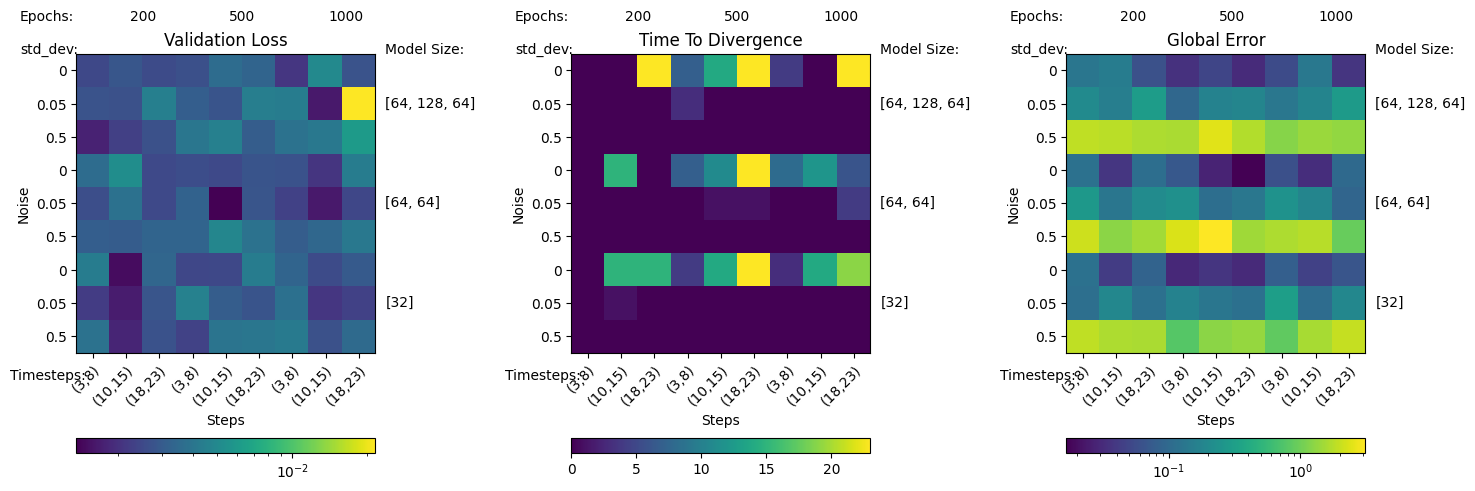

In [66]:
step_labels = ['(3,8)', '(10,15)', '(18,23)']*3
noise_labels = ['0', '0.05', '0.5']*3
figs, axs = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    if i == 1:
        im = axs[i].imshow(metric_arrays[i])
    else:
        im = axs[i].imshow(metric_arrays[i], norm=colors.LogNorm())
    axs[i].set_xticks(np.arange(9), labels=step_labels)
    axs[i].set_yticks(np.arange(9), labels=noise_labels)
    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    axs[i].set_xlabel('Steps')
    axs[i].set_ylabel('Noise')
    axs[i].text(-2.2, -.5, "std_dev:")
    axs[i].text(-2.5, 9.3, "Timesteps:")
    axs[i].text(-2.2, -1.5, "Epochs:")
    axs[i].text(8.8, -.5, "Model Size:")
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.85)
    plt.colorbar(im, orientation='horizontal', ax=axs[i], cax=cax)

    for idx, dims, num_epochs in zip([2.2,8.2,14.2], dim_sets, epochs):
        axs[i].text(8.8, idx/2, f"{dims}")
        axs[i].text(idx/2, -1.5, f"{num_epochs}")

    axs[i].set_title(f'{["Validation Loss", "Time To Divergence", "Global Error"][i]}')

figs.tight_layout()
plt.show()